# 목표

Conv based로 D 모델만 학습이 가능한지 확인.

1. 가상의 G 모델(CLSTMC, pretrained)로 testset에 대해 prediction들을 생성
2. 생성한 데이터를 npy 파일로 저장
3. D 모델에서 가짜와 진짜 데이터를 구분이 가능한지(예측 데이터와 실제 데이터에 실제로 차이가 있는지) 를 확인한다.

In [1]:
from multiprocessing import cpu_count
from pathlib import Path
from typing import List, Union, AnyStr
from math import pi
import pickle

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import model_selection
from tqdm import tqdm
import torch_optimizer
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import random
from torchvision.models.resnet import resnet18

import torch_burn as tb
import utils

In [2]:
tb.seed_everything(0)

In [3]:
EXPERIMENT_NAME = '1201-GAN-G-D'
CHECKPOINT_DIR = Path('checkpoint', EXPERIMENT_NAME)
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

DATA_DIR = Path('data/1116')
TRAIN_FILES = sorted(list(DATA_DIR.glob('*scene3_0.csv')))
TEST_FILES = sorted(list(DATA_DIR.glob('*scene3_1.csv')))

# Create Dataset

In [4]:
def load_result(checkpoint_dir):
    d = Path(checkpoint_dir)
    X = np.load(d / 'result-X.npy')
    Y = np.load(d / 'result-Y.npy')
    P = np.load(d / 'result-P.npy')
    return X, Y, P

In [5]:
X, Y, P = load_result('checkpoint/1130-Scene3-CLSTMC4-X60')

In [6]:
X.shape, Y.shape, P.shape

((54167, 60, 6), (54167, 3), (54167, 3))

In [7]:
class DetectorDataset(Dataset):
    def __init__(self, Y, P, L):
        super(DetectorDataset, self).__init__()

        self.Y = torch.tensor(Y, dtype=torch.float32).transpose(0, 1)
        self.P = torch.tensor(P, dtype=torch.float32).transpose(0, 1)
        self.L = L
        self.dssize = self.Y.shape[1] // self.L
        
        self.means = torch.stack([self.Y[0].mean(), self.Y[1].mean(), self.Y[2].mean()]).unsqueeze(1)
        self.stds = torch.stack([self.Y[0].std(), self.Y[1].std(), self.Y[2].std()]).unsqueeze(1)
        self.Y = (self.Y - self.means) / self.stds
        self.P = (self.P - self.means) / self.stds

    def __len__(self):
        return self.dssize

    def __getitem__(self, idx):
        x = self.Y[:, idx:idx + self.L]
        x_ = self.P[:, idx:idx + self.L]
        return x, x_

In [8]:
ds = DetectorDataset(Y, P, 120)

# Create Model

## Model Common Parts

In [9]:
class ResBlock1d(nn.Module):
    expansion = 1
    
    def __init__(self, inchannels, channels, kernel_size, stride=1, groups=1):
        super(ResBlock1d, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(inchannels, channels, kernel_size, padding=kernel_size // 2, stride=stride, groups=groups),
            nn.BatchNorm1d(channels),
            nn.LeakyReLU(),
            nn.Conv1d(channels, channels, kernel_size, padding=kernel_size // 2, groups=groups),
            nn.BatchNorm1d(channels)
        )
        self.act = nn.LeakyReLU()
        
        self.conv2 = None
        if inchannels != channels:
            self.conv2 = nn.Sequential(
                nn.Conv1d(inchannels, channels, 1, stride=stride, groups=groups),
                nn.BatchNorm1d(channels)
            )

    def forward(self, x):
        identity = x

        x = self.conv1(x)
        if self.conv2 is not None:
            identity = self.conv2(identity)
        x += identity
        x = self.act(x)

        return x

## D Model - Resnet15 1d

In [10]:
class ConvDetector(nn.Module):
    def __init__(self, block, layers):
        super(ConvDetector, self).__init__()
        
        self.inchannels = 64
        
        self.conv1 = nn.Sequential(
            nn.Conv1d(3, self.inchannels, 7, stride=2, padding=3, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512 * block.expansion, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.sigmoid(x)

        return x
    
    def _make_layer(self, block, channels, blocks, stride=1):
        layers = []
        layers.append(block(self.inchannels, channels, 3))
        self.inchannels = channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inchannels, channels, 3))
        
        return nn.Sequential(*layers)

## G Model - Conv Layer

In [11]:
class GModel(nn.Module):
    def __init__(self):
        super(GModel, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv1d(3, 64, 3, padding=1),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Conv1d(64, 64, 3, padding=1),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Conv1d(64, 3, 1)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

## Create Model

In [12]:
D = ConvDetector(ResBlock1d, [2, 2, 2, 2]).cuda()

In [13]:
G = GModel().cuda()

## Create Loss, Optimizer

In [14]:
d_criterion = nn.BCELoss().cuda()
g_criterion = nn.MSELoss().cuda()

In [15]:
d_optimizer = torch.optim.Adam(D.parameters())
g_optimizer = torch.optim.Adam(G.parameters())

# Training

In [16]:
valid_size = int(len(ds) * 0.2)
ds_train, ds_test = random_split(ds, [len(ds) - valid_size, valid_size])

In [17]:
dl_train = DataLoader(ds, batch_size=256, num_workers=2, pin_memory=True, shuffle=True)
dl_test  = DataLoader(ds_test,  batch_size=256, num_workers=2, pin_memory=True, shuffle=True)

In [18]:
def plot_result():
    X = np.linspace(0, x_real.shape[-1] / 6, x_real.shape[-1])

    plt.figure(figsize=(16, 4))
    plt.subplot(1, 3, 1)
    plt.plot(X, (x_real[12, 0, :].detach().cpu() * ds.stds[0]) + ds.means[0])
    plt.plot(X, (x_fake[12, 0, :].detach().cpu() * ds.stds[0]) + ds.means[0])
    plt.plot(X, (x_gen[12, 0, :].detach().cpu() * ds.stds[0]) + ds.means[0])
    plt.title('Yaw')
    plt.legend(['Real', 'Input', 'Fake'])
    plt.ylabel('Degree')
    plt.xlabel('Time (sec)')

    plt.subplot(1, 3, 2)
    plt.plot(X, (x_real[12, 1, :].detach().cpu() * ds.stds[1]) + ds.means[1])
    plt.plot(X, (x_fake[12, 1, :].detach().cpu() * ds.stds[1]) + ds.means[1])
    plt.plot(X, (x_gen[12, 1, :].detach().cpu() * ds.stds[1]) + ds.means[1])
    plt.title('Pitch')
    plt.legend(['Real', 'Input', 'Fake'])
    plt.ylabel('Degree')
    plt.xlabel('Time (sec)')

    plt.subplot(1, 3, 3)
    plt.plot(X, (x_real[12, 2, :].detach().cpu() * ds.stds[2]) + ds.means[2])
    plt.plot(X, (x_fake[12, 2, :].detach().cpu() * ds.stds[2]) + ds.means[2])
    plt.plot(X, (x_gen[12, 2, :].detach().cpu() * ds.stds[2]) + ds.means[2])
    plt.title('Roll')
    plt.legend(['Real', 'Input', 'Fake'])
    plt.ylabel('Degree')
    plt.xlabel('Time (sec)')

    plt.tight_layout()
    plt.savefig(f'results/GAN1/GAN1-epoch{epoch:03d}.png')
    plt.show()

Train Epoch[001/1000] Step [01/02] d_loss: 0.7210, d_loss_real: 0.9098, d_loss_fake: 1.4608 g_loss: 1.3795
Train Epoch[001/1000] Step [02/02] d_loss: 1.0420, d_loss_real: 0.8272, d_loss_fake: 0.8627 g_loss: 0.8572
Valid Epoch[001/1000] Step [01/01] d_loss: 0.6515, d_loss_real: 0.4880, d_loss_fake: 0.8151 g_loss: 0.8274
Train Epoch[002/1000] Step [01/02] d_loss: 0.6516, d_loss_real: 0.4856, d_loss_fake: 0.9182 g_loss: 0.9206
Train Epoch[002/1000] Step [02/02] d_loss: 0.8531, d_loss_real: 0.9024, d_loss_fake: 0.6351 g_loss: 0.6754
Valid Epoch[002/1000] Step [01/01] d_loss: 0.4753, d_loss_real: 0.3710, d_loss_fake: 0.5797 g_loss: 0.6250
Train Epoch[003/1000] Step [01/02] d_loss: 0.4641, d_loss_real: 0.3583, d_loss_fake: 0.3450 g_loss: 0.4134
Train Epoch[003/1000] Step [02/02] d_loss: 0.3078, d_loss_real: 0.2989, d_loss_fake: 0.2141 g_loss: 0.2967
Valid Epoch[003/1000] Step [01/01] d_loss: 0.2097, d_loss_real: 0.1873, d_loss_fake: 0.2321 g_loss: 0.3092
Train Epoch[004/1000] Step [01/02] d_

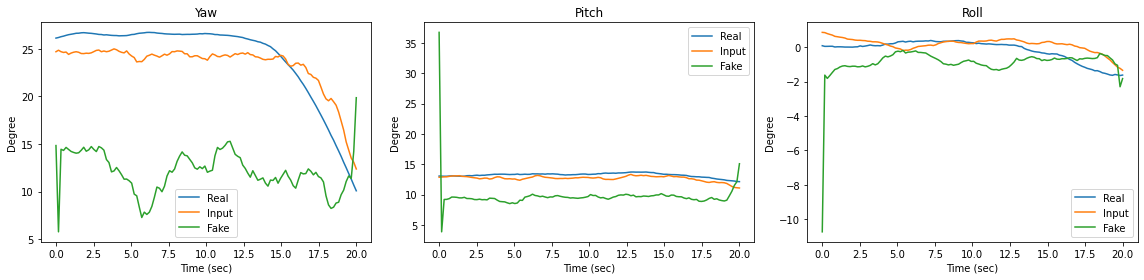

Train Epoch[011/1000] Step [01/02] d_loss: 0.0168, d_loss_real: 0.0185, d_loss_fake: 0.0124 g_loss: 0.0515
Train Epoch[011/1000] Step [02/02] d_loss: 0.0159, d_loss_real: 0.0171, d_loss_fake: 0.0117 g_loss: 0.0489
Valid Epoch[011/1000] Step [01/01] d_loss: 0.0134, d_loss_real: 0.0155, d_loss_fake: 0.0112 g_loss: 0.0469
Train Epoch[012/1000] Step [01/02] d_loss: 0.0134, d_loss_real: 0.0151, d_loss_fake: 0.0099 g_loss: 0.0455
Train Epoch[012/1000] Step [02/02] d_loss: 0.0119, d_loss_real: 0.0143, d_loss_fake: 0.0085 g_loss: 0.0433
Valid Epoch[012/1000] Step [01/01] d_loss: 0.0110, d_loss_real: 0.0131, d_loss_fake: 0.0089 g_loss: 0.0418
Train Epoch[013/1000] Step [01/02] d_loss: 0.0111, d_loss_real: 0.0128, d_loss_fake: 0.0084 g_loss: 0.0411
Train Epoch[013/1000] Step [02/02] d_loss: 0.0101, d_loss_real: 0.0123, d_loss_fake: 0.0073 g_loss: 0.0395
Valid Epoch[013/1000] Step [01/01] d_loss: 0.0093, d_loss_real: 0.0110, d_loss_fake: 0.0076 g_loss: 0.0379
Train Epoch[014/1000] Step [01/02] d_

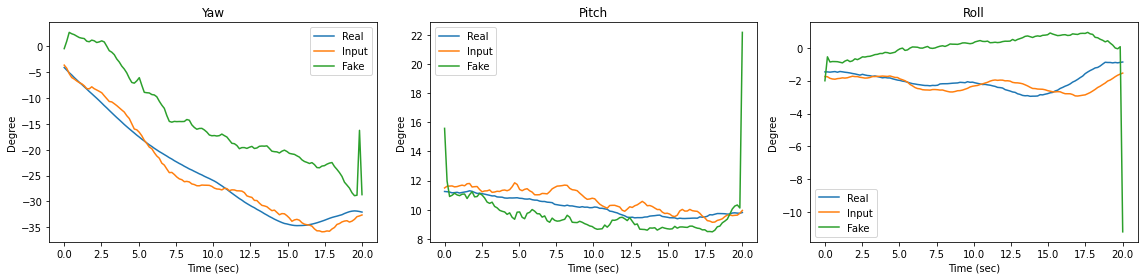

Train Epoch[021/1000] Step [01/02] d_loss: 0.0042, d_loss_real: 0.0044, d_loss_fake: 0.0036 g_loss: 0.0175
Train Epoch[021/1000] Step [02/02] d_loss: 0.0043, d_loss_real: 0.0040, d_loss_fake: 0.0040 g_loss: 0.0175
Valid Epoch[021/1000] Step [01/01] d_loss: 0.0039, d_loss_real: 0.0040, d_loss_fake: 0.0038 g_loss: 0.0163
Train Epoch[022/1000] Step [01/02] d_loss: 0.0039, d_loss_real: 0.0042, d_loss_fake: 0.0034 g_loss: 0.0160
Train Epoch[022/1000] Step [02/02] d_loss: 0.0038, d_loss_real: 0.0037, d_loss_fake: 0.0035 g_loss: 0.0155
Valid Epoch[022/1000] Step [01/01] d_loss: 0.0036, d_loss_real: 0.0037, d_loss_fake: 0.0035 g_loss: 0.0148
Train Epoch[023/1000] Step [01/02] d_loss: 0.0037, d_loss_real: 0.0036, d_loss_fake: 0.0034 g_loss: 0.0149
Train Epoch[023/1000] Step [02/02] d_loss: 0.0035, d_loss_real: 0.0038, d_loss_fake: 0.0029 g_loss: 0.0141
Valid Epoch[023/1000] Step [01/01] d_loss: 0.0033, d_loss_real: 0.0035, d_loss_fake: 0.0032 g_loss: 0.0136
Train Epoch[024/1000] Step [01/02] d_

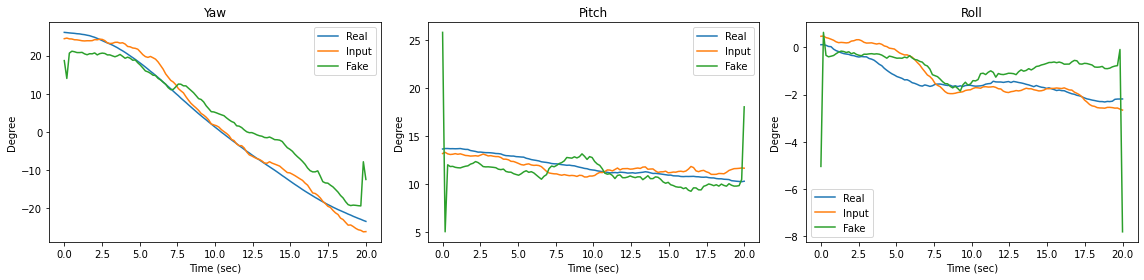

Train Epoch[031/1000] Step [01/02] d_loss: 0.0021, d_loss_real: 0.0022, d_loss_fake: 0.0018 g_loss: 0.0077
Train Epoch[031/1000] Step [02/02] d_loss: 0.0021, d_loss_real: 0.0023, d_loss_fake: 0.0019 g_loss: 0.0079
Valid Epoch[031/1000] Step [01/01] d_loss: 0.0020, d_loss_real: 0.0022, d_loss_fake: 0.0018 g_loss: 0.0074
Train Epoch[032/1000] Step [01/02] d_loss: 0.0020, d_loss_real: 0.0021, d_loss_fake: 0.0018 g_loss: 0.0074
Train Epoch[032/1000] Step [02/02] d_loss: 0.0019, d_loss_real: 0.0021, d_loss_fake: 0.0017 g_loss: 0.0070
Valid Epoch[032/1000] Step [01/01] d_loss: 0.0019, d_loss_real: 0.0021, d_loss_fake: 0.0017 g_loss: 0.0069
Train Epoch[033/1000] Step [01/02] d_loss: 0.0019, d_loss_real: 0.0021, d_loss_fake: 0.0017 g_loss: 0.0068
Train Epoch[033/1000] Step [02/02] d_loss: 0.0018, d_loss_real: 0.0019, d_loss_fake: 0.0017 g_loss: 0.0066
Valid Epoch[033/1000] Step [01/01] d_loss: 0.0018, d_loss_real: 0.0020, d_loss_fake: 0.0017 g_loss: 0.0065
Train Epoch[034/1000] Step [01/02] d_

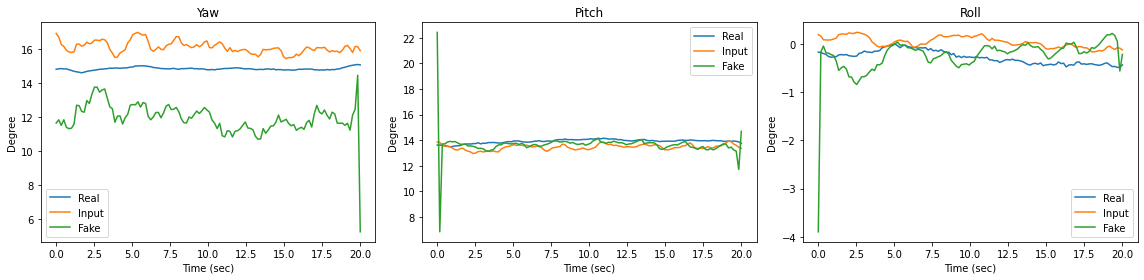

Train Epoch[041/1000] Step [01/02] d_loss: 0.0015, d_loss_real: 0.0015, d_loss_fake: 0.0013 g_loss: 0.0046
Train Epoch[041/1000] Step [02/02] d_loss: 0.0015, d_loss_real: 0.0019, d_loss_fake: 0.0012 g_loss: 0.0045
Valid Epoch[041/1000] Step [01/01] d_loss: 0.0014, d_loss_real: 0.0015, d_loss_fake: 0.0012 g_loss: 0.0042
Train Epoch[042/1000] Step [01/02] d_loss: 0.0013, d_loss_real: 0.0015, d_loss_fake: 0.0012 g_loss: 0.0042
Train Epoch[042/1000] Step [02/02] d_loss: 0.0014, d_loss_real: 0.0014, d_loss_fake: 0.0013 g_loss: 0.0042
Valid Epoch[042/1000] Step [01/01] d_loss: 0.0013, d_loss_real: 0.0014, d_loss_fake: 0.0012 g_loss: 0.0040
Train Epoch[043/1000] Step [01/02] d_loss: 0.0013, d_loss_real: 0.0014, d_loss_fake: 0.0011 g_loss: 0.0039
Train Epoch[043/1000] Step [02/02] d_loss: 0.0013, d_loss_real: 0.0014, d_loss_fake: 0.0012 g_loss: 0.0040
Valid Epoch[043/1000] Step [01/01] d_loss: 0.0013, d_loss_real: 0.0014, d_loss_fake: 0.0012 g_loss: 0.0038
Train Epoch[044/1000] Step [01/02] d_

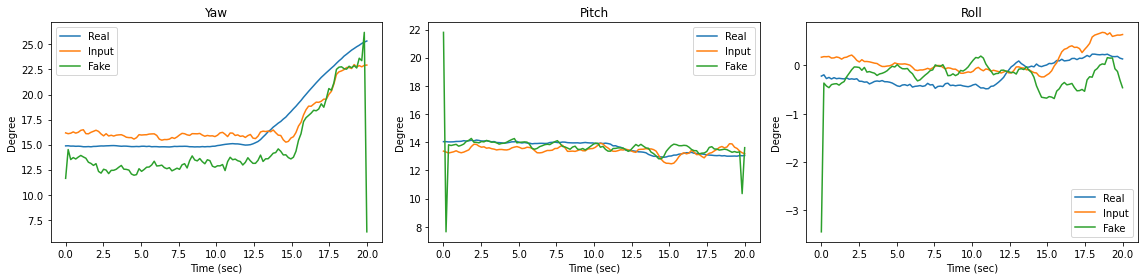

Train Epoch[051/1000] Step [01/02] d_loss: 0.0010, d_loss_real: 0.0011, d_loss_fake: 0.0009 g_loss: 0.0030
Train Epoch[051/1000] Step [02/02] d_loss: 0.0010, d_loss_real: 0.0011, d_loss_fake: 0.0009 g_loss: 0.0030
Valid Epoch[051/1000] Step [01/01] d_loss: 0.0010, d_loss_real: 0.0011, d_loss_fake: 0.0009 g_loss: 0.0030
Train Epoch[052/1000] Step [01/02] d_loss: 0.0010, d_loss_real: 0.0011, d_loss_fake: 0.0009 g_loss: 0.0029
Train Epoch[052/1000] Step [02/02] d_loss: 0.0010, d_loss_real: 0.0011, d_loss_fake: 0.0009 g_loss: 0.0029
Valid Epoch[052/1000] Step [01/01] d_loss: 0.0010, d_loss_real: 0.0011, d_loss_fake: 0.0009 g_loss: 0.0029
Train Epoch[053/1000] Step [01/02] d_loss: 0.0010, d_loss_real: 0.0011, d_loss_fake: 0.0008 g_loss: 0.0028
Train Epoch[053/1000] Step [02/02] d_loss: 0.0010, d_loss_real: 0.0011, d_loss_fake: 0.0009 g_loss: 0.0028
Valid Epoch[053/1000] Step [01/01] d_loss: 0.0010, d_loss_real: 0.0011, d_loss_fake: 0.0009 g_loss: 0.0028
Train Epoch[054/1000] Step [01/02] d_

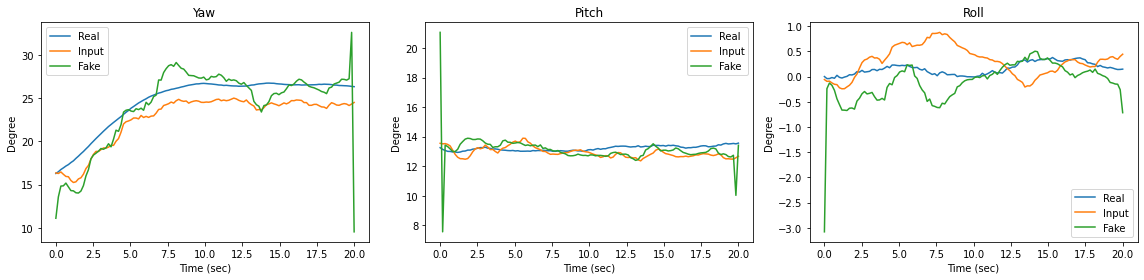

Train Epoch[061/1000] Step [01/02] d_loss: 0.0008, d_loss_real: 0.0009, d_loss_fake: 0.0007 g_loss: 0.0025
Train Epoch[061/1000] Step [02/02] d_loss: 0.0008, d_loss_real: 0.0009, d_loss_fake: 0.0007 g_loss: 0.0025
Valid Epoch[061/1000] Step [01/01] d_loss: 0.0008, d_loss_real: 0.0009, d_loss_fake: 0.0007 g_loss: 0.0024
Train Epoch[062/1000] Step [01/02] d_loss: 0.0008, d_loss_real: 0.0008, d_loss_fake: 0.0007 g_loss: 0.0023
Train Epoch[062/1000] Step [02/02] d_loss: 0.0008, d_loss_real: 0.0008, d_loss_fake: 0.0007 g_loss: 0.0023
Valid Epoch[062/1000] Step [01/01] d_loss: 0.0008, d_loss_real: 0.0009, d_loss_fake: 0.0007 g_loss: 0.0023
Train Epoch[063/1000] Step [01/02] d_loss: 0.0008, d_loss_real: 0.0009, d_loss_fake: 0.0007 g_loss: 0.0023
Train Epoch[063/1000] Step [02/02] d_loss: 0.0008, d_loss_real: 0.0008, d_loss_fake: 0.0007 g_loss: 0.0023
Valid Epoch[063/1000] Step [01/01] d_loss: 0.0008, d_loss_real: 0.0009, d_loss_fake: 0.0007 g_loss: 0.0023
Train Epoch[064/1000] Step [01/02] d_

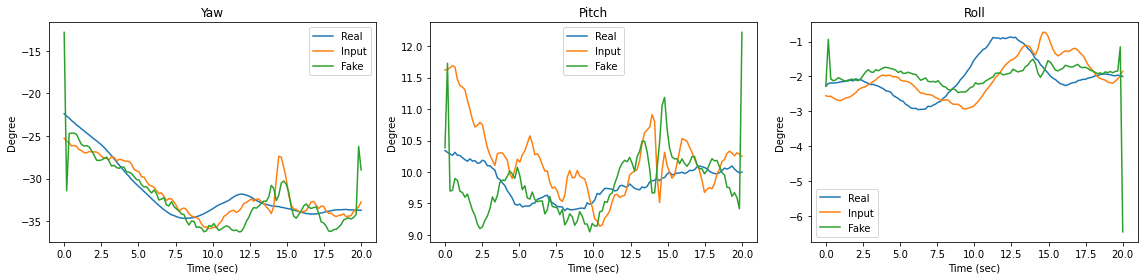

Train Epoch[071/1000] Step [01/02] d_loss: 0.0007, d_loss_real: 0.0007, d_loss_fake: 0.0006 g_loss: 0.0021
Train Epoch[071/1000] Step [02/02] d_loss: 0.0007, d_loss_real: 0.0007, d_loss_fake: 0.0006 g_loss: 0.0021
Valid Epoch[071/1000] Step [01/01] d_loss: 0.0007, d_loss_real: 0.0007, d_loss_fake: 0.0006 g_loss: 0.0020
Train Epoch[072/1000] Step [01/02] d_loss: 0.0006, d_loss_real: 0.0007, d_loss_fake: 0.0006 g_loss: 0.0020
Train Epoch[072/1000] Step [02/02] d_loss: 0.0006, d_loss_real: 0.0007, d_loss_fake: 0.0006 g_loss: 0.0020
Valid Epoch[072/1000] Step [01/01] d_loss: 0.0006, d_loss_real: 0.0007, d_loss_fake: 0.0006 g_loss: 0.0020
Train Epoch[073/1000] Step [01/02] d_loss: 0.0006, d_loss_real: 0.0007, d_loss_fake: 0.0005 g_loss: 0.0020
Train Epoch[073/1000] Step [02/02] d_loss: 0.0006, d_loss_real: 0.0007, d_loss_fake: 0.0006 g_loss: 0.0021
Valid Epoch[073/1000] Step [01/01] d_loss: 0.0006, d_loss_real: 0.0007, d_loss_fake: 0.0006 g_loss: 0.0020
Train Epoch[074/1000] Step [01/02] d_

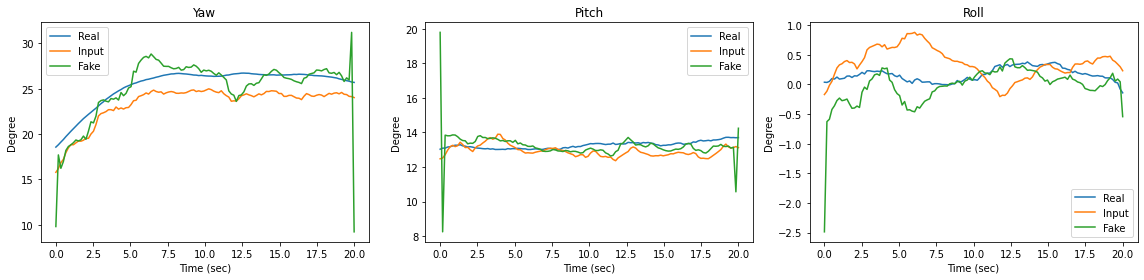

Train Epoch[081/1000] Step [01/02] d_loss: 0.0005, d_loss_real: 0.0006, d_loss_fake: 0.0005 g_loss: 0.0018
Train Epoch[081/1000] Step [02/02] d_loss: 0.0006, d_loss_real: 0.0006, d_loss_fake: 0.0005 g_loss: 0.0018
Valid Epoch[081/1000] Step [01/01] d_loss: 0.0005, d_loss_real: 0.0006, d_loss_fake: 0.0005 g_loss: 0.0018
Train Epoch[082/1000] Step [01/02] d_loss: 0.0005, d_loss_real: 0.0006, d_loss_fake: 0.0005 g_loss: 0.0018
Train Epoch[082/1000] Step [02/02] d_loss: 0.0005, d_loss_real: 0.0006, d_loss_fake: 0.0005 g_loss: 0.0018
Valid Epoch[082/1000] Step [01/01] d_loss: 0.0005, d_loss_real: 0.0006, d_loss_fake: 0.0005 g_loss: 0.0018
Train Epoch[083/1000] Step [01/02] d_loss: 0.0005, d_loss_real: 0.0006, d_loss_fake: 0.0005 g_loss: 0.0019
Train Epoch[083/1000] Step [02/02] d_loss: 0.0006, d_loss_real: 0.0006, d_loss_fake: 0.0005 g_loss: 0.0021
Valid Epoch[083/1000] Step [01/01] d_loss: 0.0005, d_loss_real: 0.0006, d_loss_fake: 0.0005 g_loss: 0.0017
Train Epoch[084/1000] Step [01/02] d_

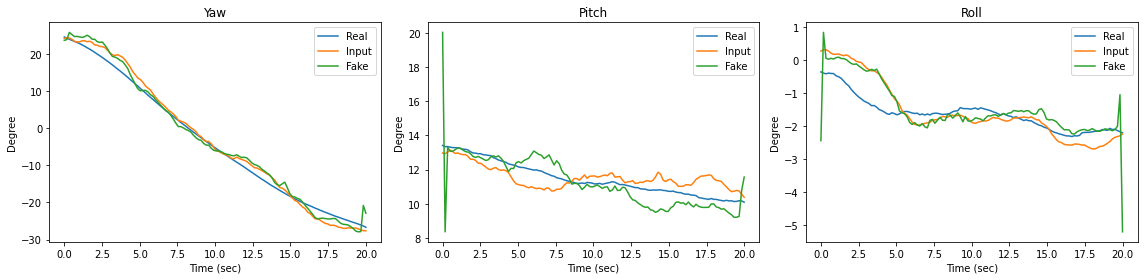

Train Epoch[091/1000] Step [01/02] d_loss: 0.0005, d_loss_real: 0.0005, d_loss_fake: 0.0004 g_loss: 0.0017
Train Epoch[091/1000] Step [02/02] d_loss: 0.0005, d_loss_real: 0.0005, d_loss_fake: 0.0004 g_loss: 0.0017
Valid Epoch[091/1000] Step [01/01] d_loss: 0.0005, d_loss_real: 0.0005, d_loss_fake: 0.0004 g_loss: 0.0016
Train Epoch[092/1000] Step [01/02] d_loss: 0.0005, d_loss_real: 0.0005, d_loss_fake: 0.0004 g_loss: 0.0016
Train Epoch[092/1000] Step [02/02] d_loss: 0.0004, d_loss_real: 0.0005, d_loss_fake: 0.0004 g_loss: 0.0016
Valid Epoch[092/1000] Step [01/01] d_loss: 0.0005, d_loss_real: 0.0005, d_loss_fake: 0.0004 g_loss: 0.0016
Train Epoch[093/1000] Step [01/02] d_loss: 0.0004, d_loss_real: 0.0005, d_loss_fake: 0.0004 g_loss: 0.0016
Train Epoch[093/1000] Step [02/02] d_loss: 0.0005, d_loss_real: 0.0005, d_loss_fake: 0.0004 g_loss: 0.0016
Valid Epoch[093/1000] Step [01/01] d_loss: 0.0004, d_loss_real: 0.0005, d_loss_fake: 0.0004 g_loss: 0.0015
Train Epoch[094/1000] Step [01/02] d_

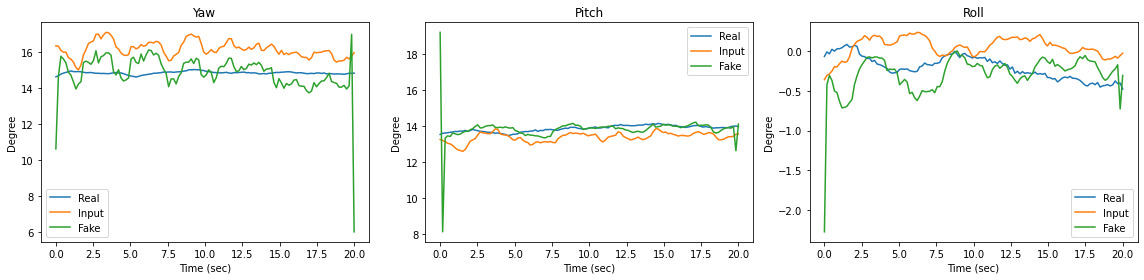

Train Epoch[101/1000] Step [01/02] d_loss: 0.0004, d_loss_real: 0.0004, d_loss_fake: 0.0004 g_loss: 0.0015
Train Epoch[101/1000] Step [02/02] d_loss: 0.0004, d_loss_real: 0.0005, d_loss_fake: 0.0004 g_loss: 0.0014
Valid Epoch[101/1000] Step [01/01] d_loss: 0.0004, d_loss_real: 0.0004, d_loss_fake: 0.0004 g_loss: 0.0014
Train Epoch[102/1000] Step [01/02] d_loss: 0.0004, d_loss_real: 0.0005, d_loss_fake: 0.0004 g_loss: 0.0014
Train Epoch[102/1000] Step [02/02] d_loss: 0.0004, d_loss_real: 0.0005, d_loss_fake: 0.0004 g_loss: 0.0015
Valid Epoch[102/1000] Step [01/01] d_loss: 0.0004, d_loss_real: 0.0004, d_loss_fake: 0.0003 g_loss: 0.0014
Train Epoch[103/1000] Step [01/02] d_loss: 0.0004, d_loss_real: 0.0005, d_loss_fake: 0.0003 g_loss: 0.0014
Train Epoch[103/1000] Step [02/02] d_loss: 0.0004, d_loss_real: 0.0004, d_loss_fake: 0.0004 g_loss: 0.0015
Valid Epoch[103/1000] Step [01/01] d_loss: 0.0004, d_loss_real: 0.0004, d_loss_fake: 0.0003 g_loss: 0.0014
Train Epoch[104/1000] Step [01/02] d_

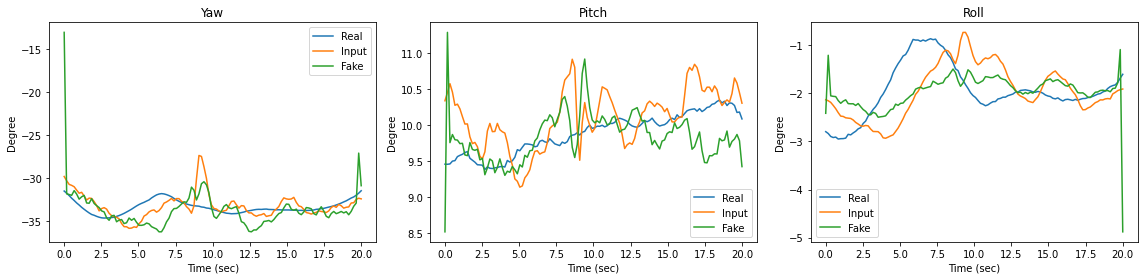

Train Epoch[111/1000] Step [01/02] d_loss: 0.0004, d_loss_real: 0.0004, d_loss_fake: 0.0003 g_loss: 0.0013
Train Epoch[111/1000] Step [02/02] d_loss: 0.0003, d_loss_real: 0.0004, d_loss_fake: 0.0003 g_loss: 0.0013
Valid Epoch[111/1000] Step [01/01] d_loss: 0.0004, d_loss_real: 0.0004, d_loss_fake: 0.0003 g_loss: 0.0013
Train Epoch[112/1000] Step [01/02] d_loss: 0.0003, d_loss_real: 0.0004, d_loss_fake: 0.0003 g_loss: 0.0014
Train Epoch[112/1000] Step [02/02] d_loss: 0.0004, d_loss_real: 0.0004, d_loss_fake: 0.0003 g_loss: 0.0014
Valid Epoch[112/1000] Step [01/01] d_loss: 0.0003, d_loss_real: 0.0004, d_loss_fake: 0.0003 g_loss: 0.0013
Train Epoch[113/1000] Step [01/02] d_loss: 0.0003, d_loss_real: 0.0004, d_loss_fake: 0.0003 g_loss: 0.0013
Train Epoch[113/1000] Step [02/02] d_loss: 0.0004, d_loss_real: 0.0004, d_loss_fake: 0.0003 g_loss: 0.0013
Valid Epoch[113/1000] Step [01/01] d_loss: 0.0003, d_loss_real: 0.0004, d_loss_fake: 0.0003 g_loss: 0.0013
Train Epoch[114/1000] Step [01/02] d_

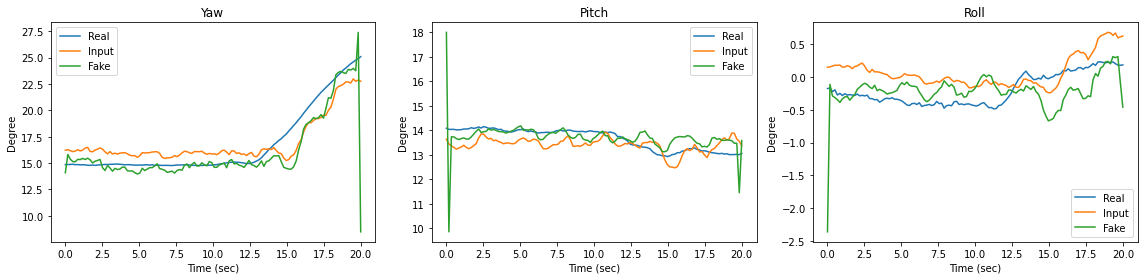

Train Epoch[121/1000] Step [01/02] d_loss: 0.0003, d_loss_real: 0.0004, d_loss_fake: 0.0003 g_loss: 0.0014
Train Epoch[121/1000] Step [02/02] d_loss: 0.0003, d_loss_real: 0.0004, d_loss_fake: 0.0003 g_loss: 0.0015
Valid Epoch[121/1000] Step [01/01] d_loss: 0.0003, d_loss_real: 0.0003, d_loss_fake: 0.0003 g_loss: 0.0012
Train Epoch[122/1000] Step [01/02] d_loss: 0.0003, d_loss_real: 0.0004, d_loss_fake: 0.0003 g_loss: 0.0015
Train Epoch[122/1000] Step [02/02] d_loss: 0.0004, d_loss_real: 0.0004, d_loss_fake: 0.0004 g_loss: 0.0018
Valid Epoch[122/1000] Step [01/01] d_loss: 0.0003, d_loss_real: 0.0003, d_loss_fake: 0.0003 g_loss: 0.0012
Train Epoch[123/1000] Step [01/02] d_loss: 0.0003, d_loss_real: 0.0003, d_loss_fake: 0.0003 g_loss: 0.0012
Train Epoch[123/1000] Step [02/02] d_loss: 0.0003, d_loss_real: 0.0003, d_loss_fake: 0.0003 g_loss: 0.0012
Valid Epoch[123/1000] Step [01/01] d_loss: 0.0003, d_loss_real: 0.0003, d_loss_fake: 0.0003 g_loss: 0.0012
Train Epoch[124/1000] Step [01/02] d_

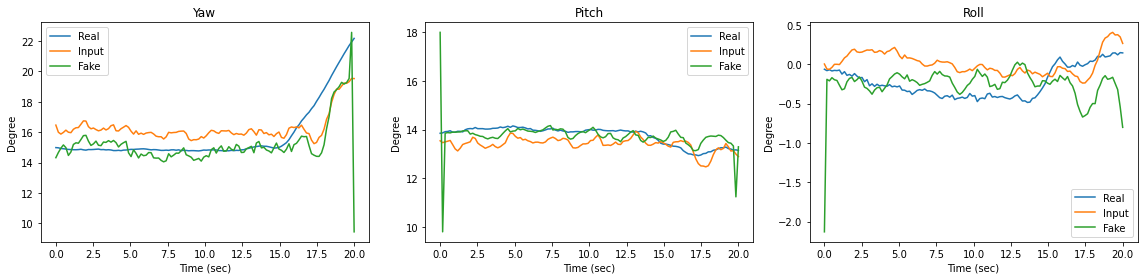

Train Epoch[131/1000] Step [01/02] d_loss: 0.0003, d_loss_real: 0.0003, d_loss_fake: 0.0002 g_loss: 0.0012
Train Epoch[131/1000] Step [02/02] d_loss: 0.0003, d_loss_real: 0.0003, d_loss_fake: 0.0003 g_loss: 0.0012
Valid Epoch[131/1000] Step [01/01] d_loss: 0.0003, d_loss_real: 0.0003, d_loss_fake: 0.0002 g_loss: 0.0011
Train Epoch[132/1000] Step [01/02] d_loss: 0.0003, d_loss_real: 0.0003, d_loss_fake: 0.0002 g_loss: 0.0011
Train Epoch[132/1000] Step [02/02] d_loss: 0.0003, d_loss_real: 0.0003, d_loss_fake: 0.0003 g_loss: 0.0011
Valid Epoch[132/1000] Step [01/01] d_loss: 0.0003, d_loss_real: 0.0003, d_loss_fake: 0.0002 g_loss: 0.0011
Train Epoch[133/1000] Step [01/02] d_loss: 0.0003, d_loss_real: 0.0003, d_loss_fake: 0.0002 g_loss: 0.0011
Train Epoch[133/1000] Step [02/02] d_loss: 0.0003, d_loss_real: 0.0003, d_loss_fake: 0.0002 g_loss: 0.0011
Valid Epoch[133/1000] Step [01/01] d_loss: 0.0003, d_loss_real: 0.0003, d_loss_fake: 0.0002 g_loss: 0.0011
Train Epoch[134/1000] Step [01/02] d_

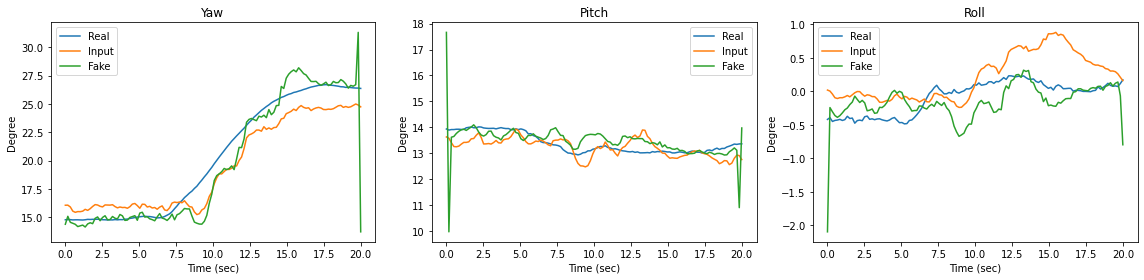

Train Epoch[141/1000] Step [01/02] d_loss: 0.0003, d_loss_real: 0.0003, d_loss_fake: 0.0002 g_loss: 0.0012
Train Epoch[141/1000] Step [02/02] d_loss: 0.0003, d_loss_real: 0.0003, d_loss_fake: 0.0002 g_loss: 0.0013
Valid Epoch[141/1000] Step [01/01] d_loss: 0.0002, d_loss_real: 0.0003, d_loss_fake: 0.0002 g_loss: 0.0010
Train Epoch[142/1000] Step [01/02] d_loss: 0.0002, d_loss_real: 0.0003, d_loss_fake: 0.0002 g_loss: 0.0011
Train Epoch[142/1000] Step [02/02] d_loss: 0.0003, d_loss_real: 0.0003, d_loss_fake: 0.0002 g_loss: 0.0011
Valid Epoch[142/1000] Step [01/01] d_loss: 0.0002, d_loss_real: 0.0003, d_loss_fake: 0.0002 g_loss: 0.0010
Train Epoch[143/1000] Step [01/02] d_loss: 0.0002, d_loss_real: 0.0003, d_loss_fake: 0.0002 g_loss: 0.0011
Train Epoch[143/1000] Step [02/02] d_loss: 0.0003, d_loss_real: 0.0003, d_loss_fake: 0.0002 g_loss: 0.0011
Valid Epoch[143/1000] Step [01/01] d_loss: 0.0002, d_loss_real: 0.0003, d_loss_fake: 0.0002 g_loss: 0.0010
Train Epoch[144/1000] Step [01/02] d_

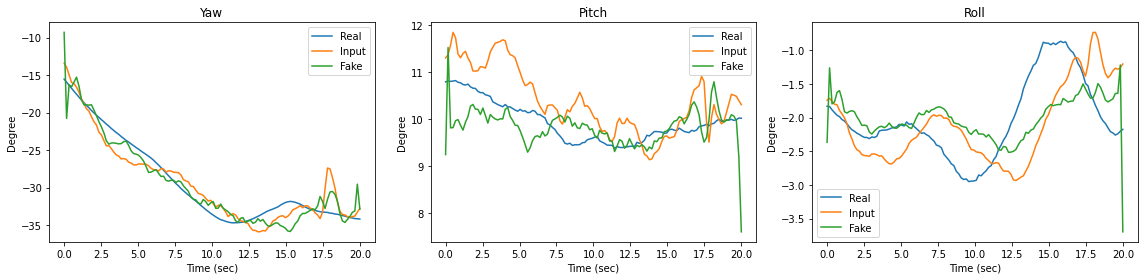

Train Epoch[151/1000] Step [01/02] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0010
Train Epoch[151/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0010
Valid Epoch[151/1000] Step [01/01] d_loss: 0.0002, d_loss_real: 0.0003, d_loss_fake: 0.0002 g_loss: 0.0010
Train Epoch[152/1000] Step [01/02] d_loss: 0.0002, d_loss_real: 0.0003, d_loss_fake: 0.0002 g_loss: 0.0011
Train Epoch[152/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0013
Valid Epoch[152/1000] Step [01/01] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0010
Train Epoch[153/1000] Step [01/02] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0011
Train Epoch[153/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0011
Valid Epoch[153/1000] Step [01/01] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0010
Train Epoch[154/1000] Step [01/02] d_

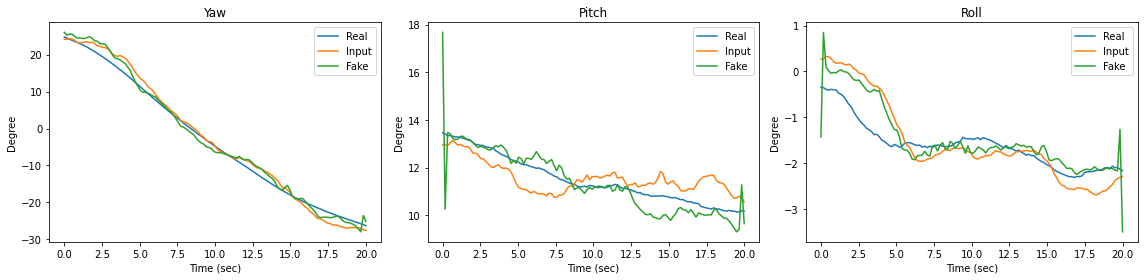

Train Epoch[161/1000] Step [01/02] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0010
Train Epoch[161/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0010
Valid Epoch[161/1000] Step [01/01] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0009
Train Epoch[162/1000] Step [01/02] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0011
Train Epoch[162/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0011
Valid Epoch[162/1000] Step [01/01] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0009
Train Epoch[163/1000] Step [01/02] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0009
Train Epoch[163/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0009
Valid Epoch[163/1000] Step [01/01] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0009
Train Epoch[164/1000] Step [01/02] d_

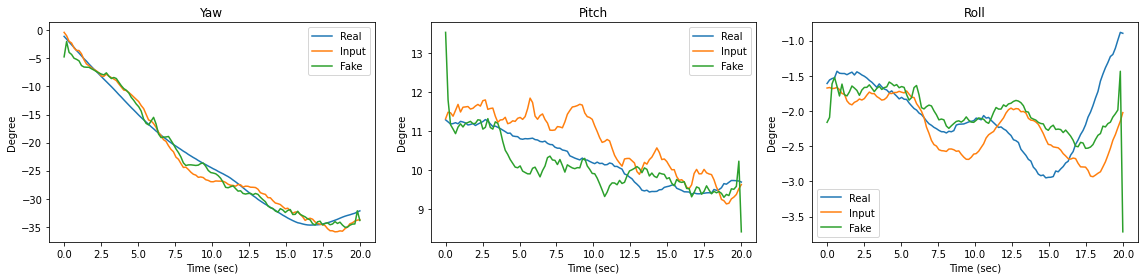

Train Epoch[171/1000] Step [01/02] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0009
Train Epoch[171/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0009
Valid Epoch[171/1000] Step [01/01] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0009
Train Epoch[172/1000] Step [01/02] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0009
Train Epoch[172/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0009
Valid Epoch[172/1000] Step [01/01] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0009
Train Epoch[173/1000] Step [01/02] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0010
Train Epoch[173/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0010
Valid Epoch[173/1000] Step [01/01] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0009
Train Epoch[174/1000] Step [01/02] d_

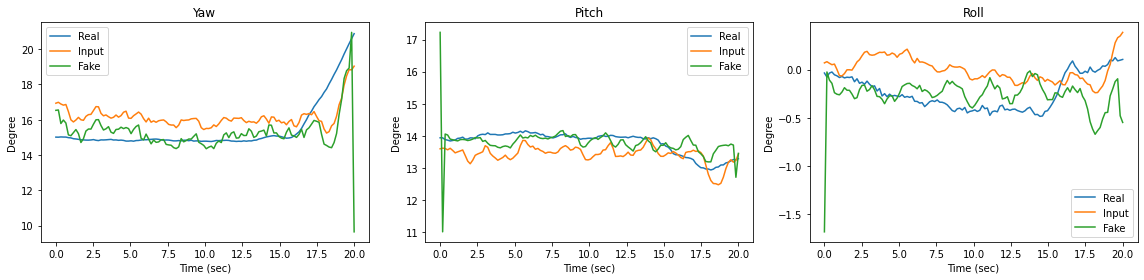

Train Epoch[181/1000] Step [01/02] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0009
Train Epoch[181/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0009
Valid Epoch[181/1000] Step [01/01] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0008
Train Epoch[182/1000] Step [01/02] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0008
Train Epoch[182/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0009
Valid Epoch[182/1000] Step [01/01] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0008
Train Epoch[183/1000] Step [01/02] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0009
Train Epoch[183/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0009
Valid Epoch[183/1000] Step [01/01] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0008
Train Epoch[184/1000] Step [01/02] d_

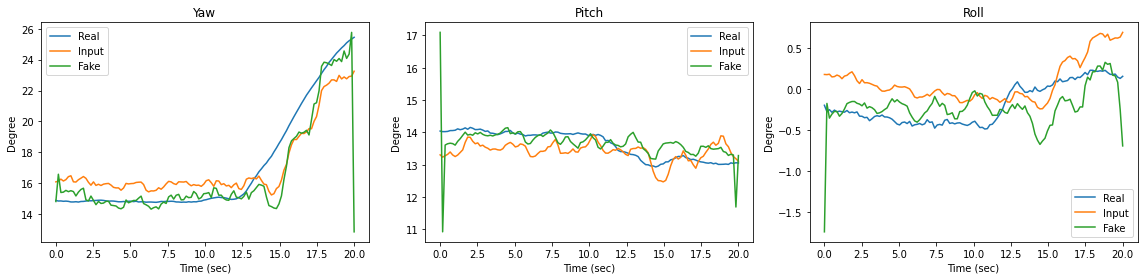

Train Epoch[191/1000] Step [01/02] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0001 g_loss: 0.0008
Train Epoch[191/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0009
Valid Epoch[191/1000] Step [01/01] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0001 g_loss: 0.0008
Train Epoch[192/1000] Step [01/02] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0009
Train Epoch[192/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0002 g_loss: 0.0009
Valid Epoch[192/1000] Step [01/01] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0001 g_loss: 0.0008
Train Epoch[193/1000] Step [01/02] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0001 g_loss: 0.0008
Train Epoch[193/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0001 g_loss: 0.0008
Valid Epoch[193/1000] Step [01/01] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0001 g_loss: 0.0008
Train Epoch[194/1000] Step [01/02] d_

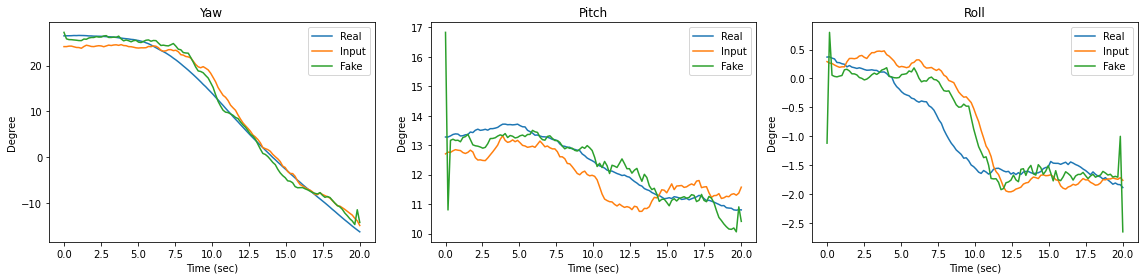

Train Epoch[201/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0002, d_loss_fake: 0.0001 g_loss: 0.0008
Train Epoch[201/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0001 g_loss: 0.0008
Valid Epoch[201/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0002, d_loss_fake: 0.0001 g_loss: 0.0008
Train Epoch[202/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0002, d_loss_fake: 0.0001 g_loss: 0.0008
Train Epoch[202/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0002, d_loss_fake: 0.0001 g_loss: 0.0008
Valid Epoch[202/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0002, d_loss_fake: 0.0001 g_loss: 0.0008
Train Epoch[203/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0002, d_loss_fake: 0.0001 g_loss: 0.0008
Train Epoch[203/1000] Step [02/02] d_loss: 0.0002, d_loss_real: 0.0002, d_loss_fake: 0.0001 g_loss: 0.0009
Valid Epoch[203/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0002, d_loss_fake: 0.0001 g_loss: 0.0008
Train Epoch[204/1000] Step [01/02] d_

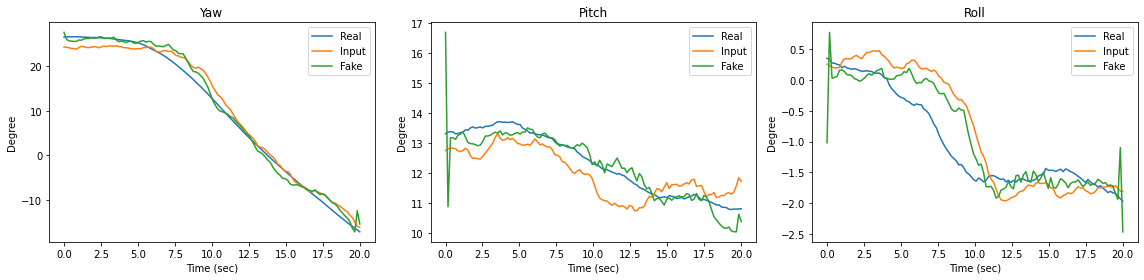

Train Epoch[211/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0008
Train Epoch[211/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0002, d_loss_fake: 0.0001 g_loss: 0.0009
Valid Epoch[211/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0002, d_loss_fake: 0.0001 g_loss: 0.0007
Train Epoch[212/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0008
Train Epoch[212/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0002, d_loss_fake: 0.0001 g_loss: 0.0008
Valid Epoch[212/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0002, d_loss_fake: 0.0001 g_loss: 0.0007
Train Epoch[213/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0007
Train Epoch[213/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0007
Valid Epoch[213/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0002, d_loss_fake: 0.0001 g_loss: 0.0007
Train Epoch[214/1000] Step [01/02] d_

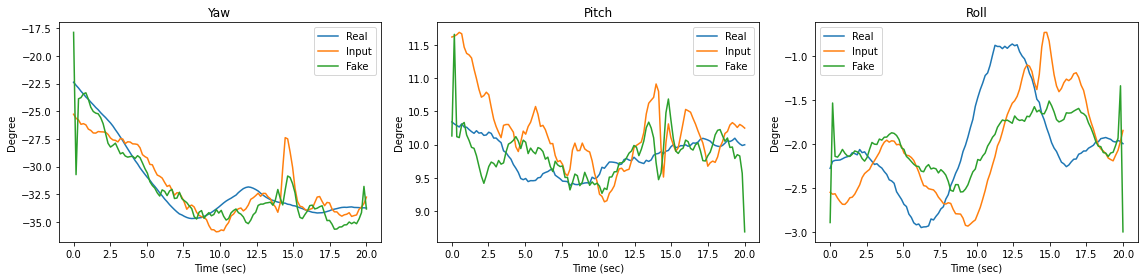

Train Epoch[221/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0008
Train Epoch[221/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0008
Valid Epoch[221/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0007
Train Epoch[222/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0008
Train Epoch[222/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0008
Valid Epoch[222/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0007
Train Epoch[223/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0008
Train Epoch[223/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0008
Valid Epoch[223/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0007
Train Epoch[224/1000] Step [01/02] d_

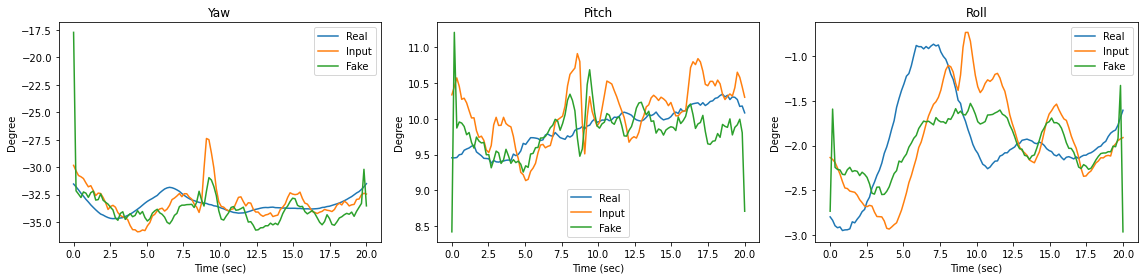

Train Epoch[231/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0007
Train Epoch[231/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0007
Valid Epoch[231/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0007
Train Epoch[232/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0007
Train Epoch[232/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0008
Valid Epoch[232/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0007
Train Epoch[233/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0007
Train Epoch[233/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0007
Valid Epoch[233/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0007
Train Epoch[234/1000] Step [01/02] d_

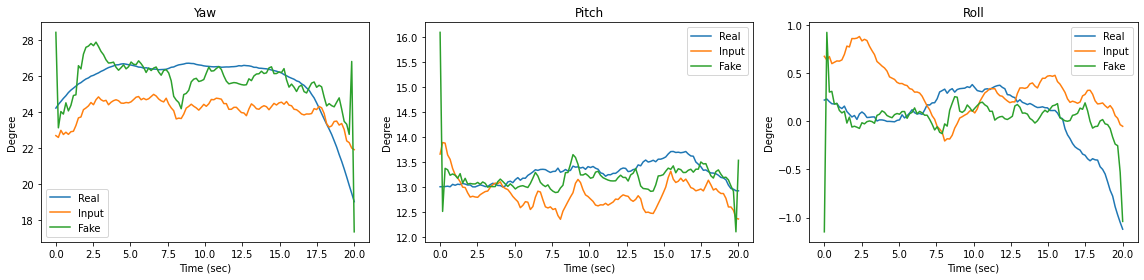

Train Epoch[241/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0007
Train Epoch[241/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0008
Valid Epoch[241/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0007
Train Epoch[242/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0007
Train Epoch[242/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0007
Valid Epoch[242/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0007
Train Epoch[243/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0007
Train Epoch[243/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0007
Valid Epoch[243/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0007
Train Epoch[244/1000] Step [01/02] d_

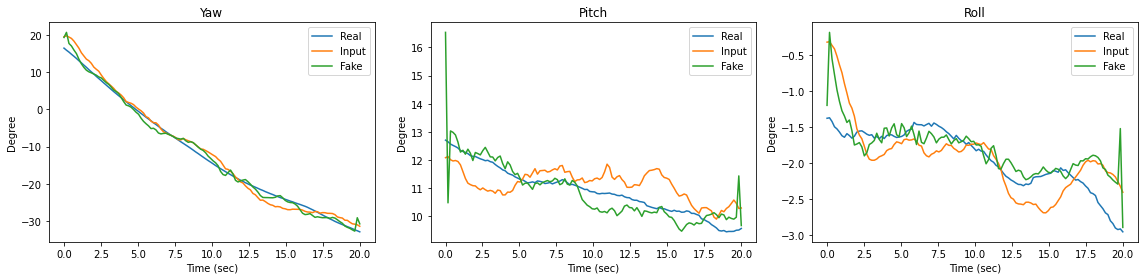

Train Epoch[251/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0007
Train Epoch[251/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0008
Valid Epoch[251/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Train Epoch[252/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0007
Train Epoch[252/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0008
Valid Epoch[252/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Train Epoch[253/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0007
Train Epoch[253/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0008
Valid Epoch[253/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Train Epoch[254/1000] Step [01/02] d_

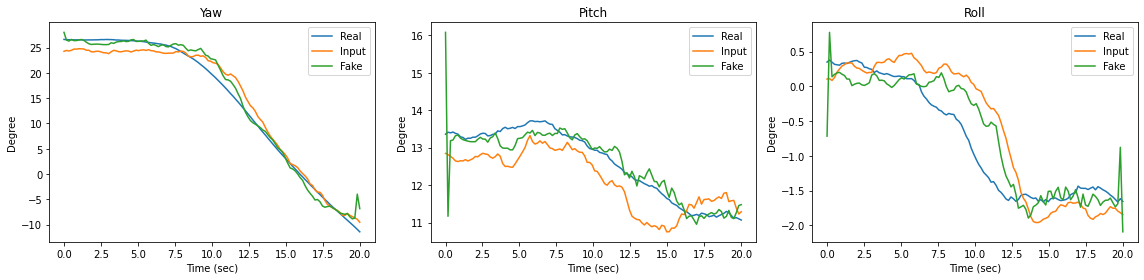

Train Epoch[261/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Train Epoch[261/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0007
Valid Epoch[261/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Train Epoch[262/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Train Epoch[262/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Valid Epoch[262/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Train Epoch[263/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Train Epoch[263/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Valid Epoch[263/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Train Epoch[264/1000] Step [01/02] d_

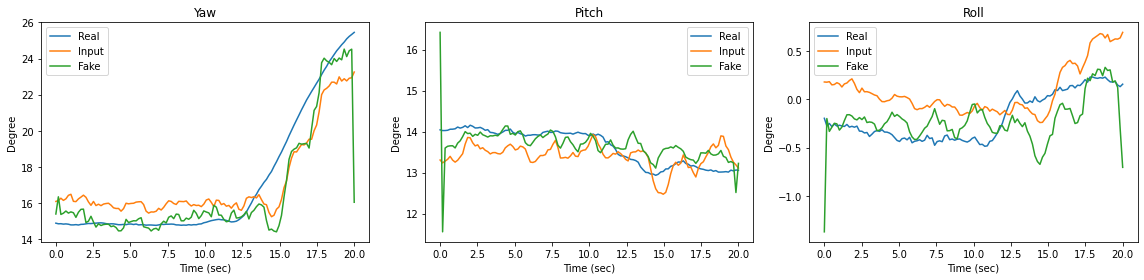

Train Epoch[271/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0007
Train Epoch[271/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0007
Valid Epoch[271/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Train Epoch[272/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Train Epoch[272/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Valid Epoch[272/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Train Epoch[273/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0007
Train Epoch[273/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0007
Valid Epoch[273/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Train Epoch[274/1000] Step [01/02] d_

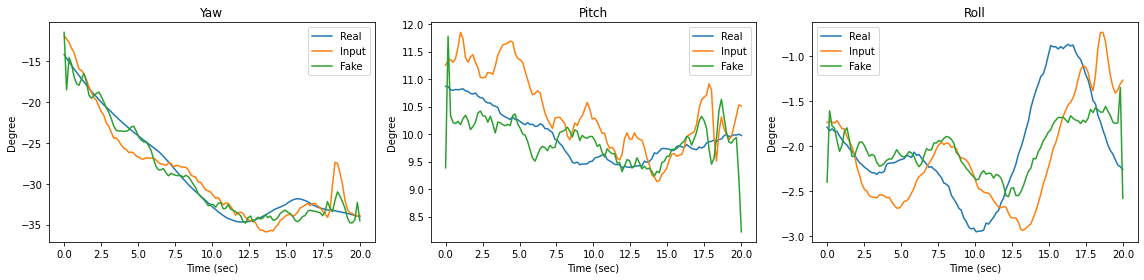

Train Epoch[281/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Train Epoch[281/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Valid Epoch[281/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Train Epoch[282/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Train Epoch[282/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Valid Epoch[282/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Train Epoch[283/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0008
Train Epoch[283/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0010
Valid Epoch[283/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Train Epoch[284/1000] Step [01/02] d_

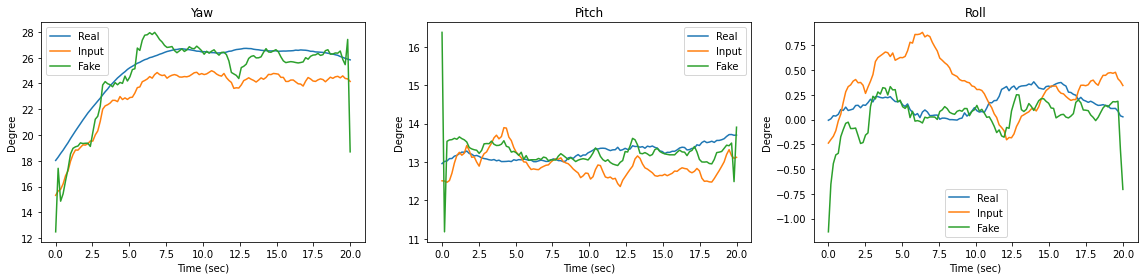

Train Epoch[291/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Train Epoch[291/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Valid Epoch[291/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Train Epoch[292/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Train Epoch[292/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0007
Valid Epoch[292/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Train Epoch[293/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0009
Train Epoch[293/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0010
Valid Epoch[293/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Train Epoch[294/1000] Step [01/02] d_

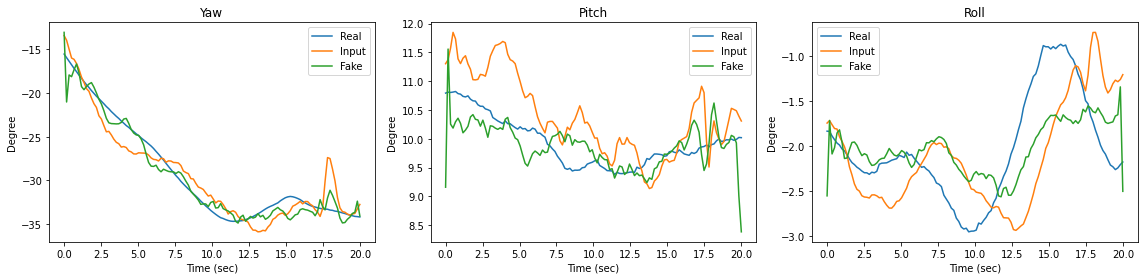

Train Epoch[301/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Train Epoch[301/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Valid Epoch[301/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Train Epoch[302/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0011
Train Epoch[302/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0014
Valid Epoch[302/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Train Epoch[303/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Train Epoch[303/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Valid Epoch[303/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Train Epoch[304/1000] Step [01/02] d_

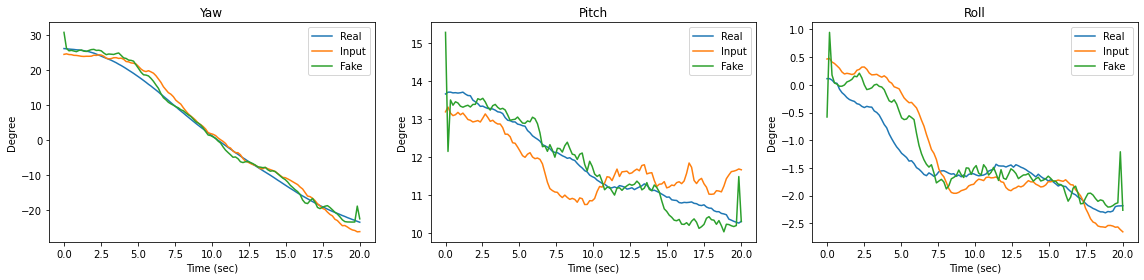

Train Epoch[311/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Train Epoch[311/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Valid Epoch[311/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Train Epoch[312/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0008
Train Epoch[312/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0008
Valid Epoch[312/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Train Epoch[313/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Train Epoch[313/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Valid Epoch[313/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Train Epoch[314/1000] Step [01/02] d_

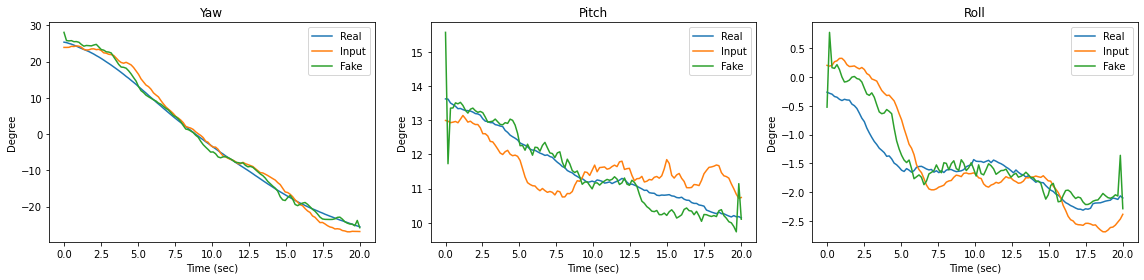

Train Epoch[321/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0005
Train Epoch[321/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Valid Epoch[321/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0005
Train Epoch[322/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Train Epoch[322/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Valid Epoch[322/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0005
Train Epoch[323/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Train Epoch[323/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Valid Epoch[323/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0005
Train Epoch[324/1000] Step [01/02] d_

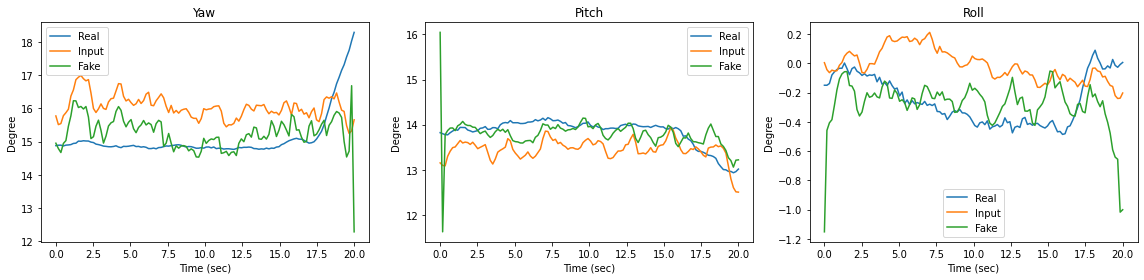

Train Epoch[331/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Train Epoch[331/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Valid Epoch[331/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0005
Train Epoch[332/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Train Epoch[332/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0007
Valid Epoch[332/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0005
Train Epoch[333/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Train Epoch[333/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0007
Valid Epoch[333/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0005
Train Epoch[334/1000] Step [01/02] d_

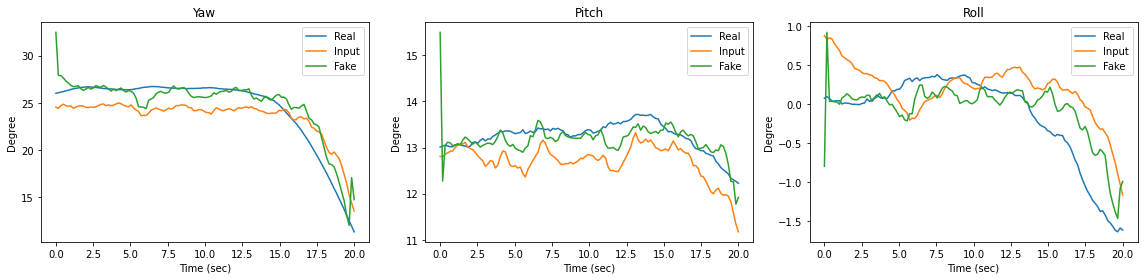

Train Epoch[341/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Train Epoch[341/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Valid Epoch[341/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0005
Train Epoch[342/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Train Epoch[342/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Valid Epoch[342/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0005
Train Epoch[343/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0005
Train Epoch[343/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0005
Valid Epoch[343/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0005
Train Epoch[344/1000] Step [01/02] d_

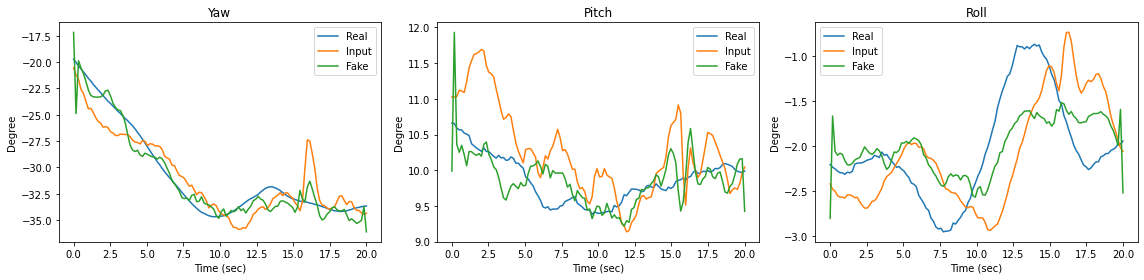

Train Epoch[351/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0005
Train Epoch[351/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0005
Valid Epoch[351/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0005
Train Epoch[352/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0005
Train Epoch[352/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0005
Valid Epoch[352/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0005
Train Epoch[353/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0005
Train Epoch[353/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Valid Epoch[353/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0005
Train Epoch[354/1000] Step [01/02] d_

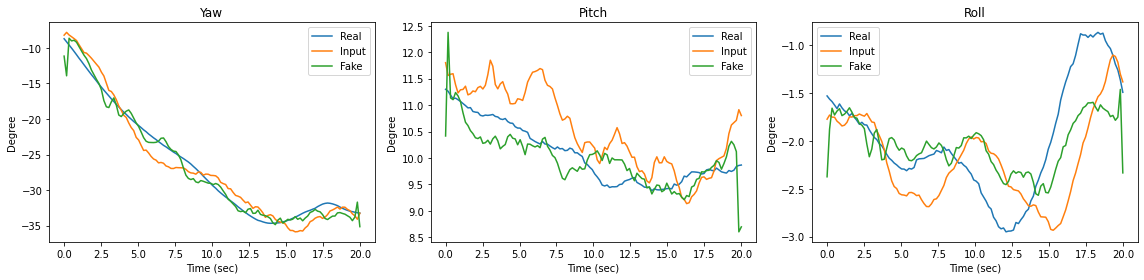

Train Epoch[361/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Train Epoch[361/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Valid Epoch[361/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0005
Train Epoch[362/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0005
Train Epoch[362/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0005
Valid Epoch[362/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0005
Train Epoch[363/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0005
Train Epoch[363/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0005
Valid Epoch[363/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0005
Train Epoch[364/1000] Step [01/02] d_

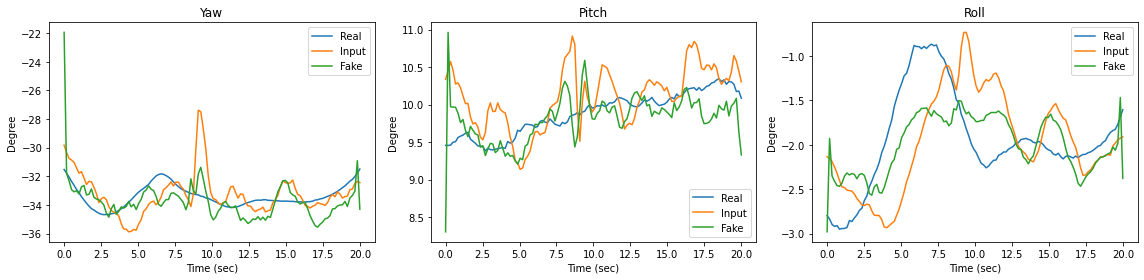

Train Epoch[371/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Train Epoch[371/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Valid Epoch[371/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0005
Train Epoch[372/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0005
Train Epoch[372/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Valid Epoch[372/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0005
Train Epoch[373/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0005
Train Epoch[373/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0005
Valid Epoch[373/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0005
Train Epoch[374/1000] Step [01/02] d_

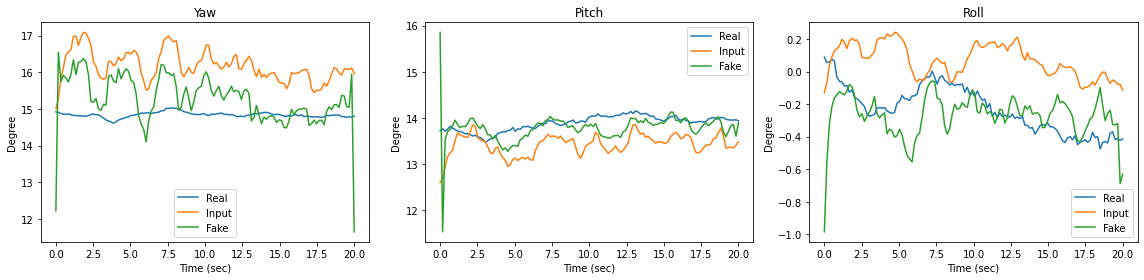

Train Epoch[381/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0005
Train Epoch[381/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0005
Valid Epoch[381/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[382/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0005
Train Epoch[382/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0006
Valid Epoch[382/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[383/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0005
Train Epoch[383/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0005
Valid Epoch[383/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[384/1000] Step [01/02] d_

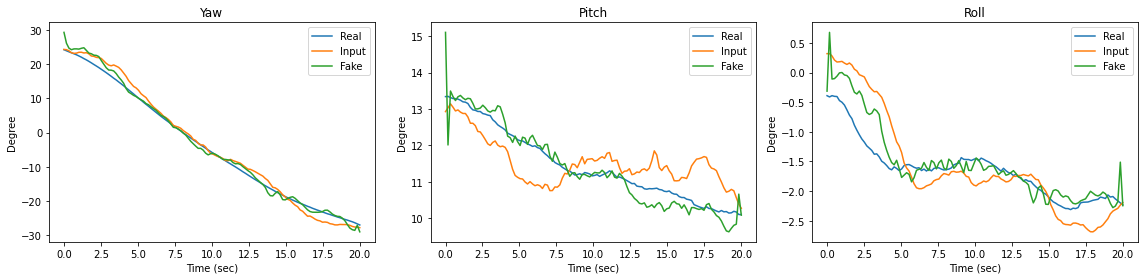

Train Epoch[391/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[391/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0005
Valid Epoch[391/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[392/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0005
Train Epoch[392/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0005
Valid Epoch[392/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[393/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0008
Train Epoch[393/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0011
Valid Epoch[393/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[394/1000] Step [01/02] d_

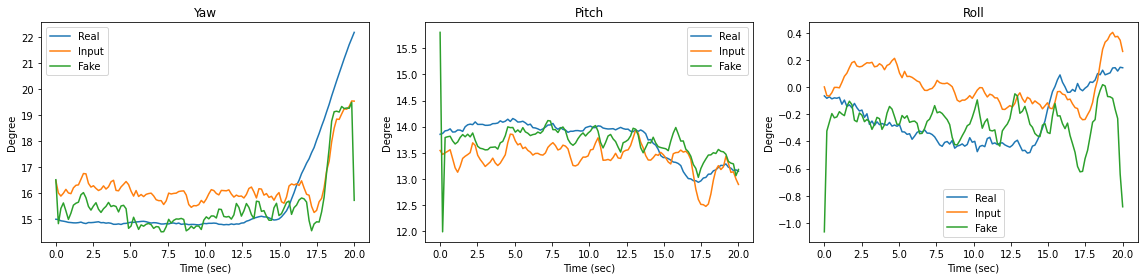

Train Epoch[401/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[401/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0005
Valid Epoch[401/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[402/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[402/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0005
Valid Epoch[402/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[403/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[403/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0005
Valid Epoch[403/1000] Step [01/01] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[404/1000] Step [01/02] d_

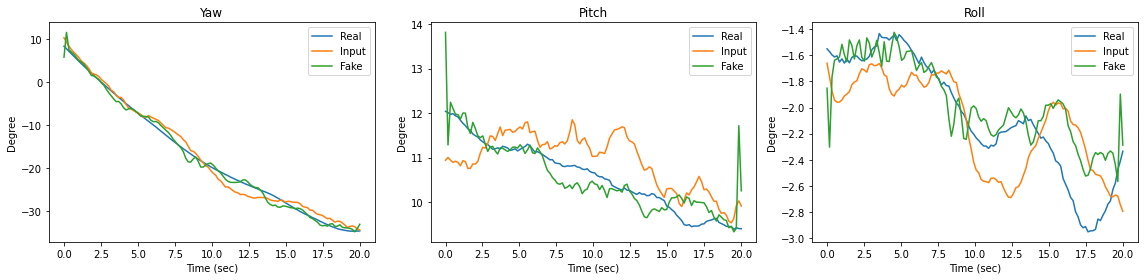

Train Epoch[411/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[411/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0005
Valid Epoch[411/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[412/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[412/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0005
Valid Epoch[412/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[413/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[413/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0005
Valid Epoch[413/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[414/1000] Step [01/02] d_

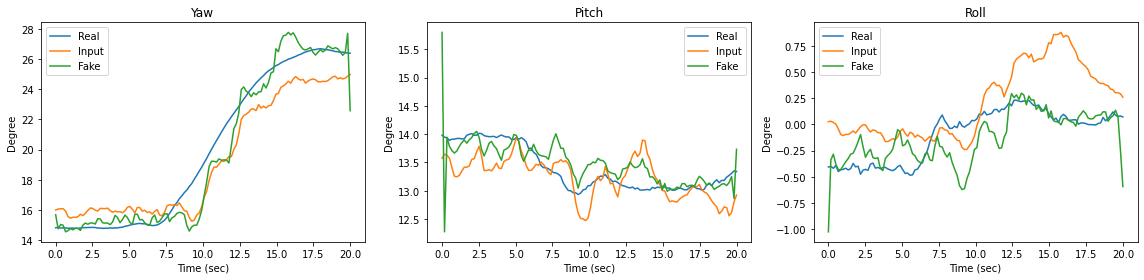

Train Epoch[421/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[421/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0006
Valid Epoch[421/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[422/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[422/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0005
Valid Epoch[422/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[423/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[423/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0006
Valid Epoch[423/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[424/1000] Step [01/02] d_

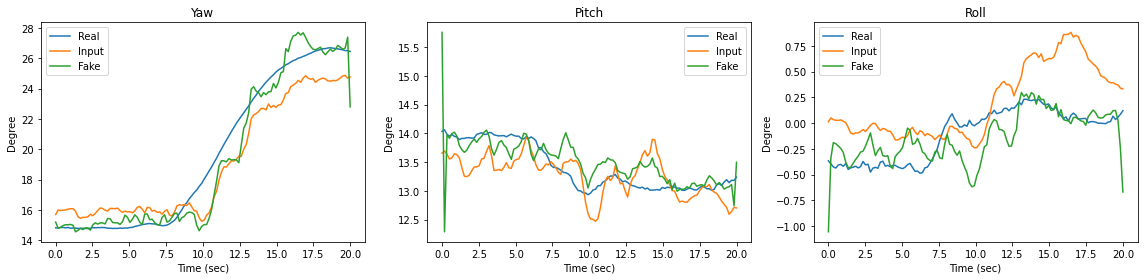

Train Epoch[431/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[431/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0005
Valid Epoch[431/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[432/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0010
Train Epoch[432/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0015
Valid Epoch[432/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[433/1000] Step [01/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0006
Train Epoch[433/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0007
Valid Epoch[433/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[434/1000] Step [01/02] d_

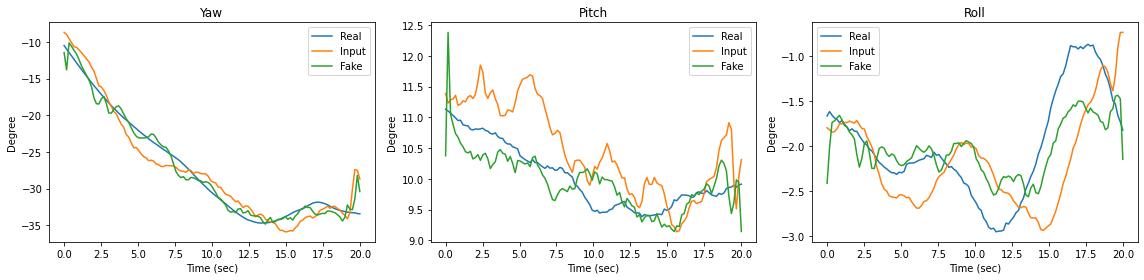

Train Epoch[441/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[441/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Valid Epoch[441/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[442/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[442/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Valid Epoch[442/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[443/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[443/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Valid Epoch[443/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[444/1000] Step [01/02] d_

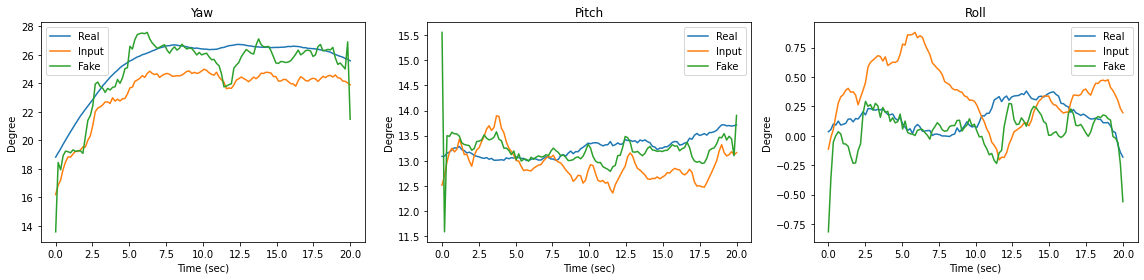

Train Epoch[451/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[451/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Valid Epoch[451/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[452/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[452/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Valid Epoch[452/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[453/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0006
Train Epoch[453/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0008
Valid Epoch[453/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[454/1000] Step [01/02] d_

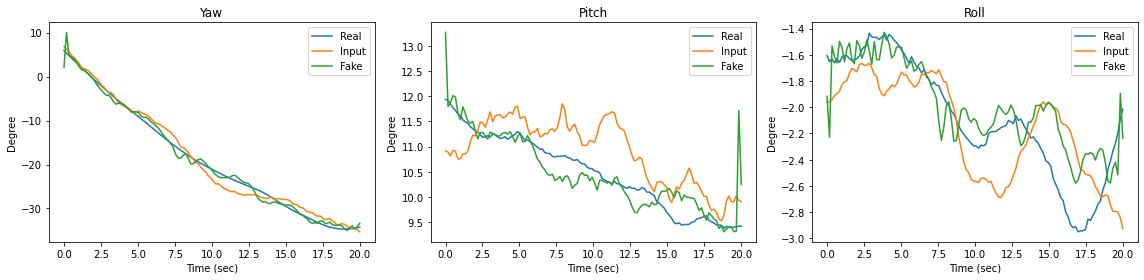

Train Epoch[461/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[461/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Valid Epoch[461/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[462/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[462/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[462/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[463/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[463/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[463/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[464/1000] Step [01/02] d_

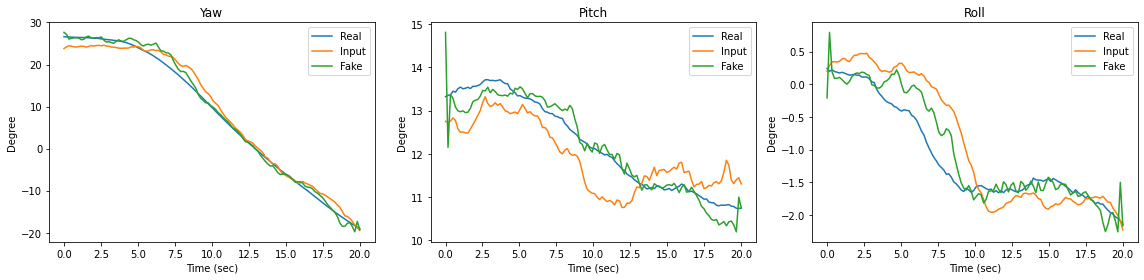

Train Epoch[471/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0007
Train Epoch[471/1000] Step [02/02] d_loss: 0.0001, d_loss_real: 0.0001, d_loss_fake: 0.0001 g_loss: 0.0009
Valid Epoch[471/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[472/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[472/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Valid Epoch[472/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[473/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[473/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[473/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[474/1000] Step [01/02] d_

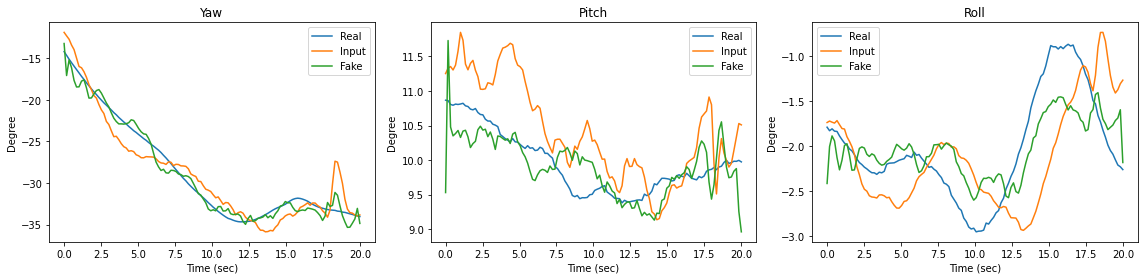

Train Epoch[481/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0007
Train Epoch[481/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0009
Valid Epoch[481/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[482/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[482/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0006
Valid Epoch[482/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[483/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[483/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[483/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[484/1000] Step [01/02] d_

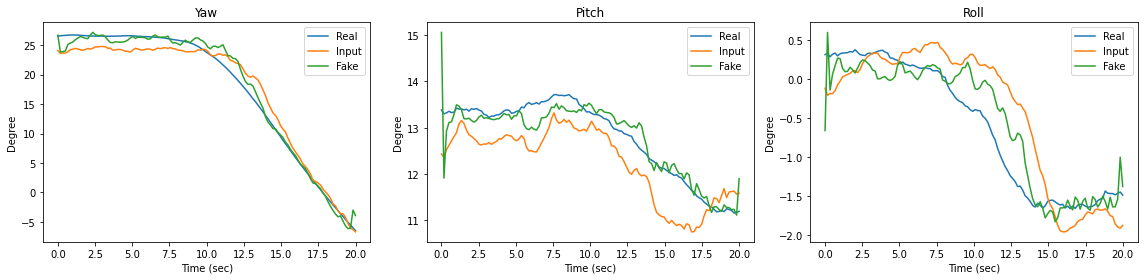

Train Epoch[491/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[491/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[491/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[492/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[492/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Valid Epoch[492/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[493/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[493/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[493/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[494/1000] Step [01/02] d_

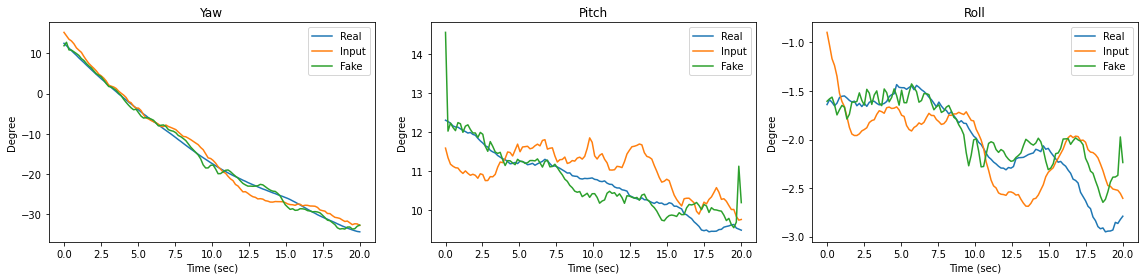

Train Epoch[501/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[501/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0006
Valid Epoch[501/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[502/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[502/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[502/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[503/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[503/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[503/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[504/1000] Step [01/02] d_

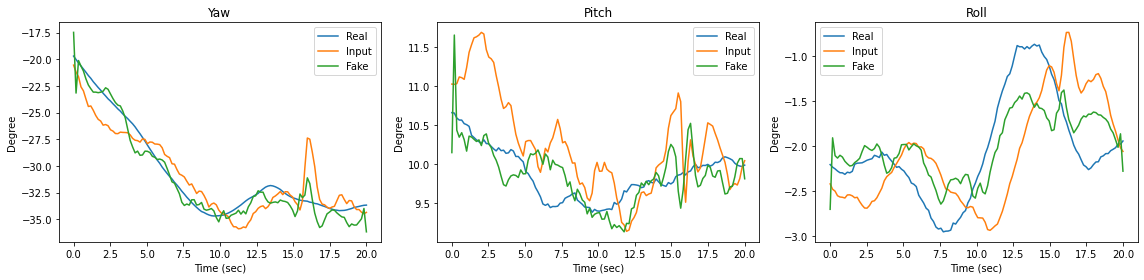

Train Epoch[511/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[511/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[511/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[512/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[512/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[512/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[513/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[513/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Valid Epoch[513/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[514/1000] Step [01/02] d_

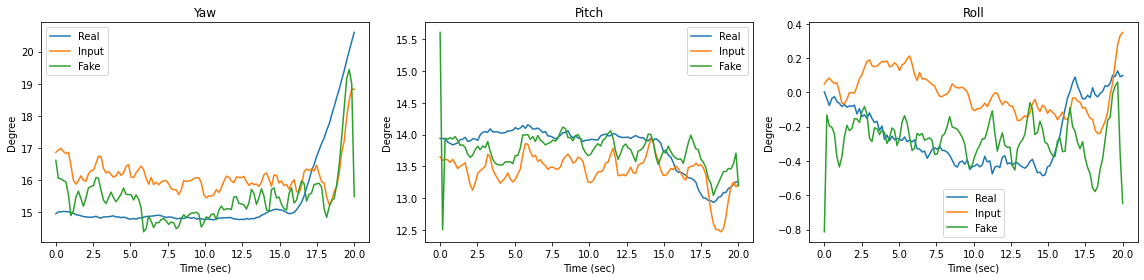

Train Epoch[521/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[521/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Valid Epoch[521/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[522/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[522/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[522/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[523/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[523/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[523/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[524/1000] Step [01/02] d_

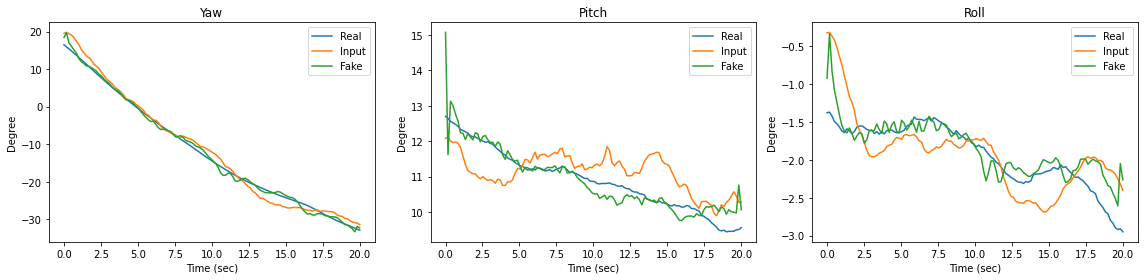

Train Epoch[531/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[531/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[531/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[532/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0007
Train Epoch[532/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0010
Valid Epoch[532/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[533/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[533/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[533/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[534/1000] Step [01/02] d_

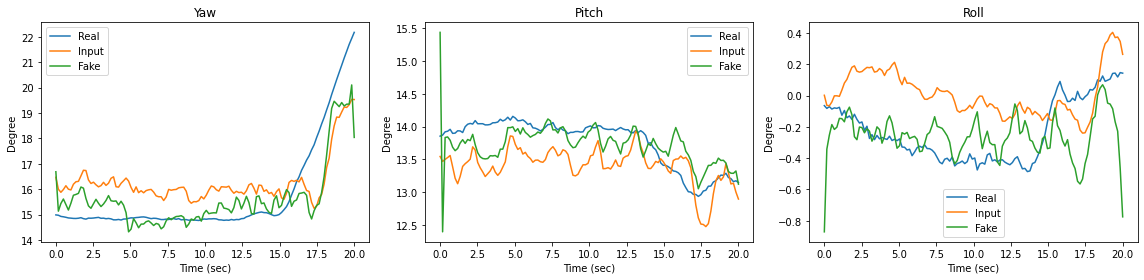

Train Epoch[541/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[541/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Valid Epoch[541/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[542/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[542/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0006
Valid Epoch[542/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[543/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[543/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[543/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[544/1000] Step [01/02] d_

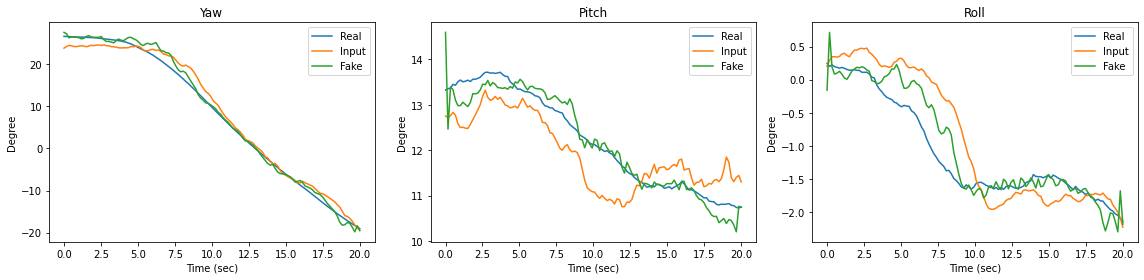

Train Epoch[551/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[551/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[551/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[552/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[552/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0001, d_loss_fake: 0.0000 g_loss: 0.0006
Valid Epoch[552/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[553/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[553/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0007
Valid Epoch[553/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[554/1000] Step [01/02] d_

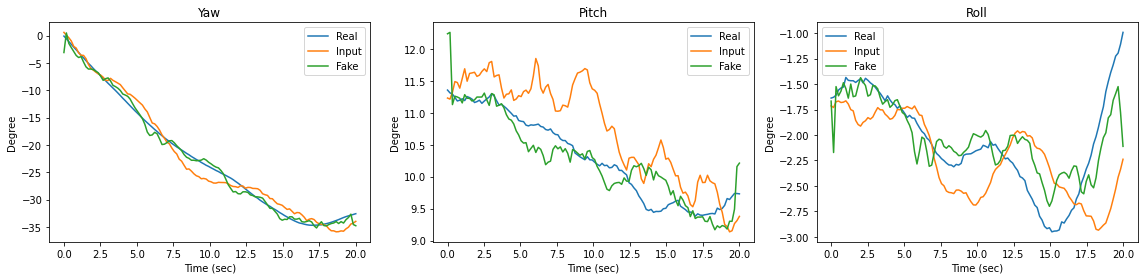

Train Epoch[561/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[561/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[561/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[562/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[562/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0006
Valid Epoch[562/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[563/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[563/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Valid Epoch[563/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[564/1000] Step [01/02] d_

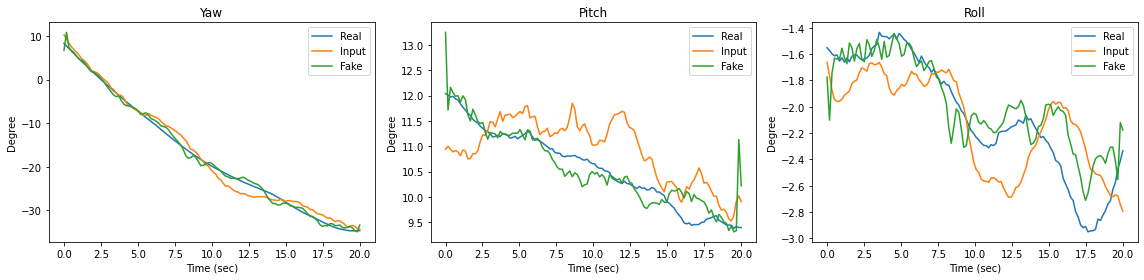

Train Epoch[571/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[571/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Valid Epoch[571/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[572/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[572/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[572/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[573/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[573/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[573/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[574/1000] Step [01/02] d_

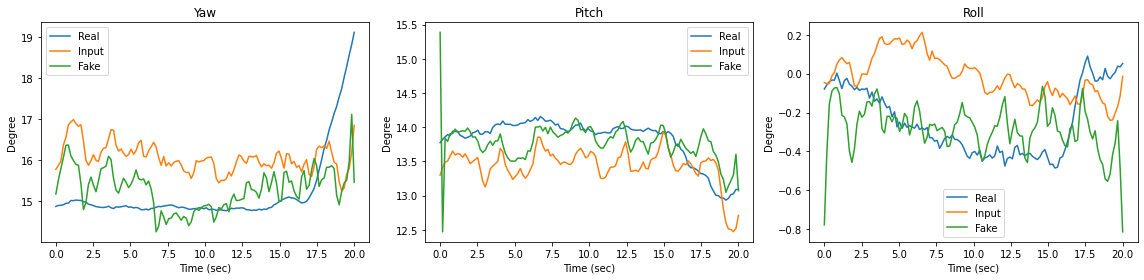

Train Epoch[581/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[581/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[581/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[582/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[582/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[582/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[583/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[583/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Valid Epoch[583/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[584/1000] Step [01/02] d_

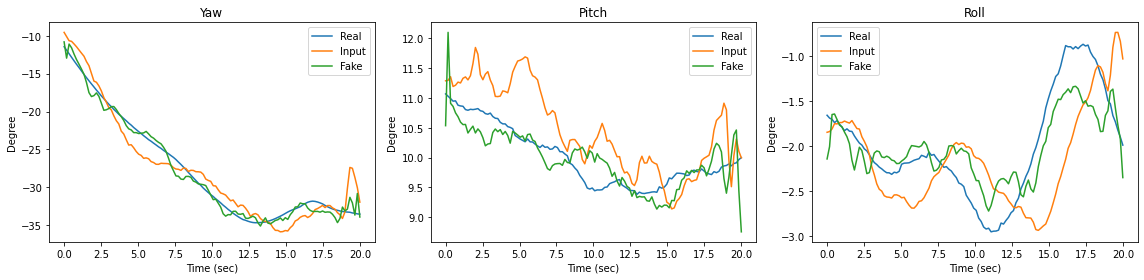

Train Epoch[591/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0006
Train Epoch[591/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0007
Valid Epoch[591/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[592/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[592/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0007
Valid Epoch[592/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[593/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[593/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[593/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[594/1000] Step [01/02] d_

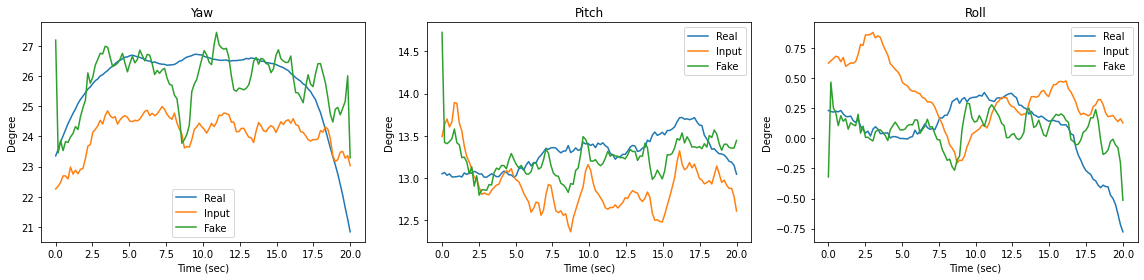

Train Epoch[601/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0006
Train Epoch[601/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0007
Valid Epoch[601/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[602/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[602/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[602/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[603/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[603/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[603/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[604/1000] Step [01/02] d_

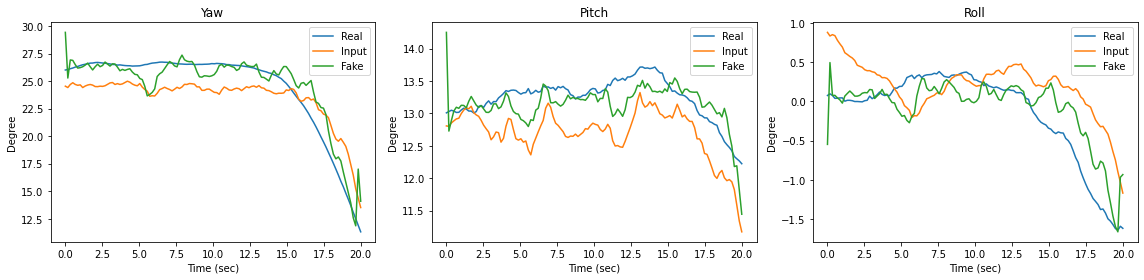

Train Epoch[611/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[611/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[611/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[612/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[612/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[612/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[613/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0006
Train Epoch[613/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0009
Valid Epoch[613/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[614/1000] Step [01/02] d_

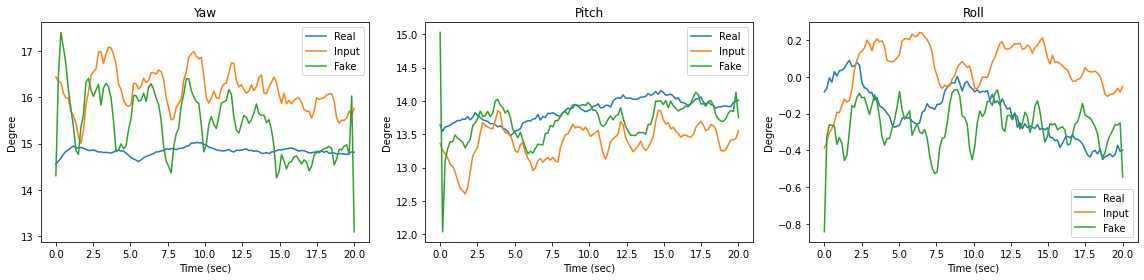

Train Epoch[621/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[621/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[621/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[622/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[622/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[622/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[623/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[623/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[623/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[624/1000] Step [01/02] d_

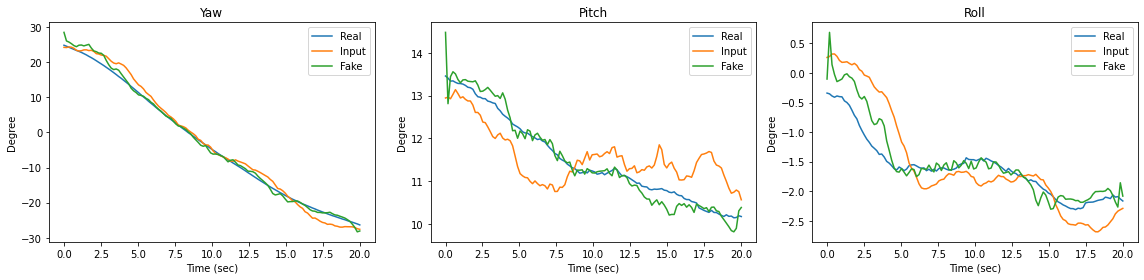

Train Epoch[631/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[631/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[631/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[632/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[632/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[632/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[633/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[633/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[633/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[634/1000] Step [01/02] d_

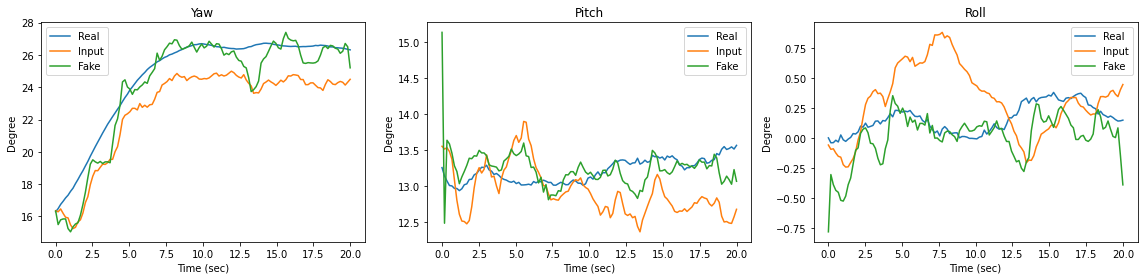

Train Epoch[641/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[641/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[641/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[642/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[642/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[642/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[643/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[643/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[643/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[644/1000] Step [01/02] d_

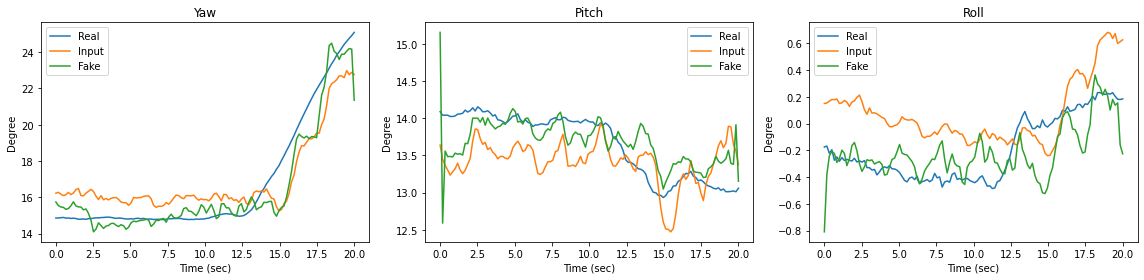

Train Epoch[651/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[651/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Valid Epoch[651/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[652/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[652/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0006
Valid Epoch[652/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[653/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[653/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[653/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[654/1000] Step [01/02] d_

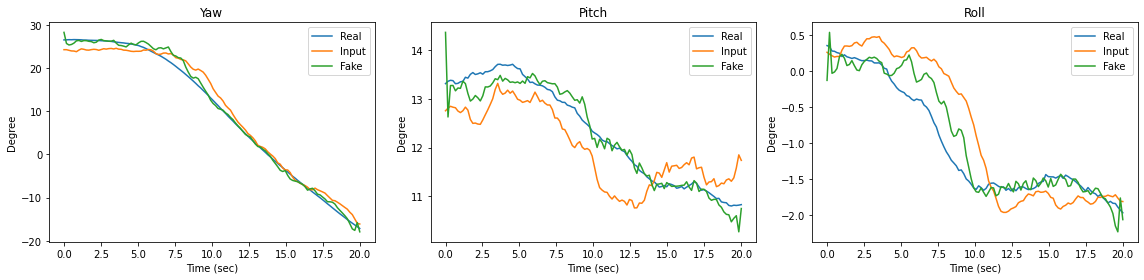

Train Epoch[661/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[661/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[661/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[662/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[662/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[662/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[663/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[663/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0007
Valid Epoch[663/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[664/1000] Step [01/02] d_

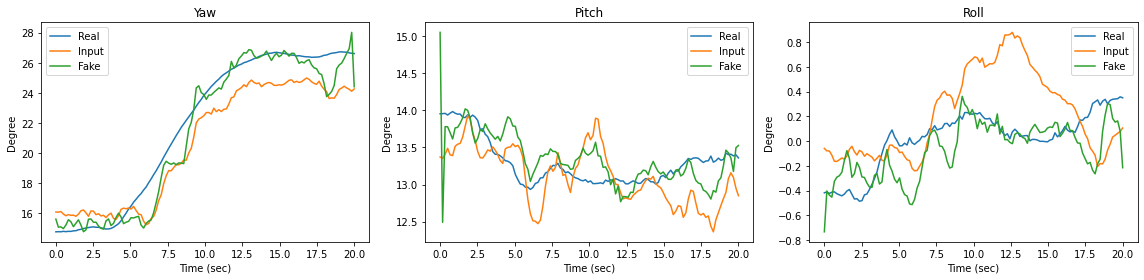

Train Epoch[671/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[671/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[671/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[672/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[672/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[672/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[673/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[673/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[673/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[674/1000] Step [01/02] d_

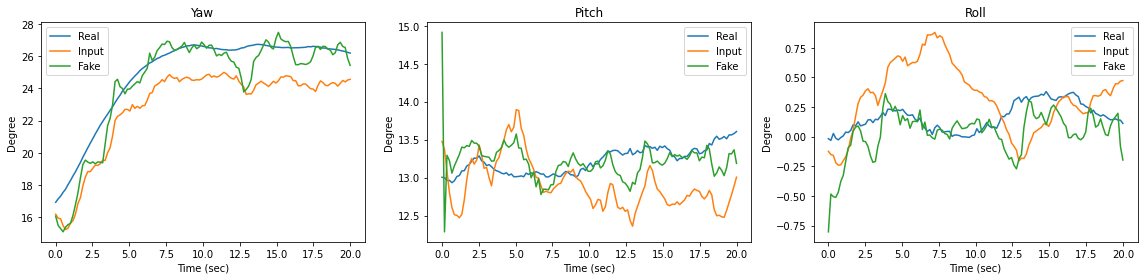

Train Epoch[681/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[681/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0006
Valid Epoch[681/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[682/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[682/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[682/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[683/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[683/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[683/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[684/1000] Step [01/02] d_

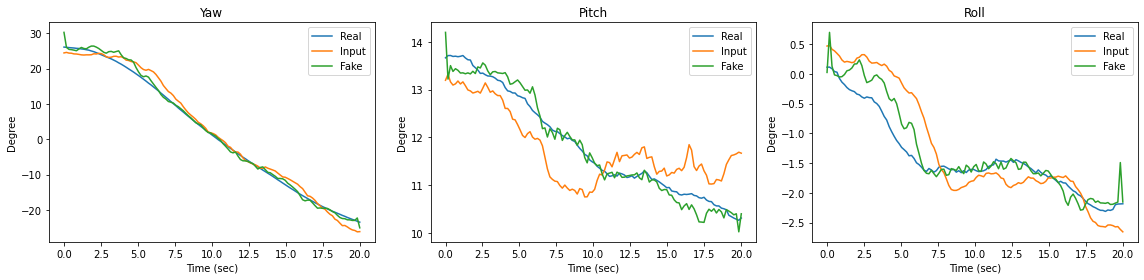

Train Epoch[691/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[691/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[691/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[692/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[692/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[692/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[693/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[693/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0006
Valid Epoch[693/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[694/1000] Step [01/02] d_

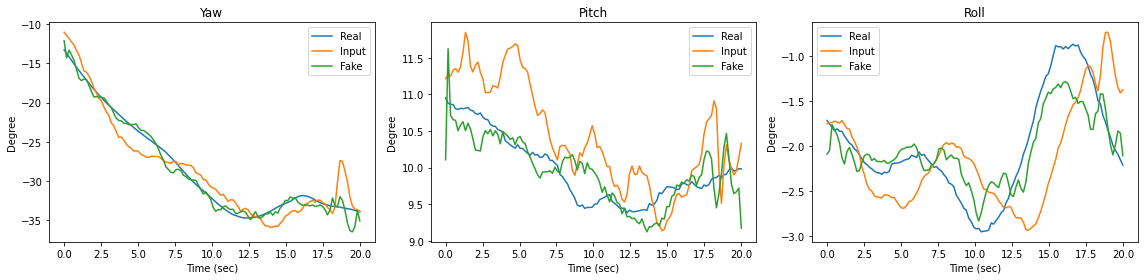

Train Epoch[701/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[701/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[701/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[702/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[702/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[702/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[703/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[703/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Valid Epoch[703/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[704/1000] Step [01/02] d_

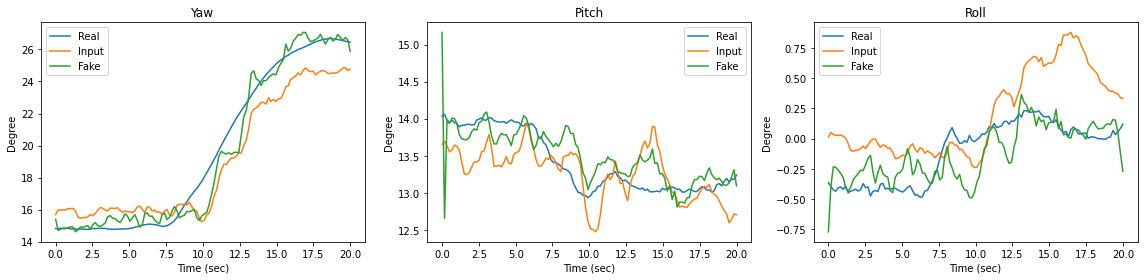

Train Epoch[711/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[711/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Valid Epoch[711/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[712/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[712/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[712/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[713/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[713/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[713/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[714/1000] Step [01/02] d_

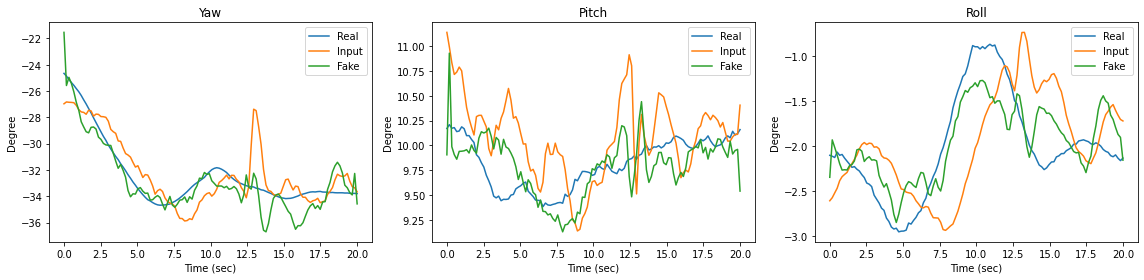

Train Epoch[721/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[721/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Valid Epoch[721/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[722/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[722/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[722/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[723/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[723/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[723/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[724/1000] Step [01/02] d_

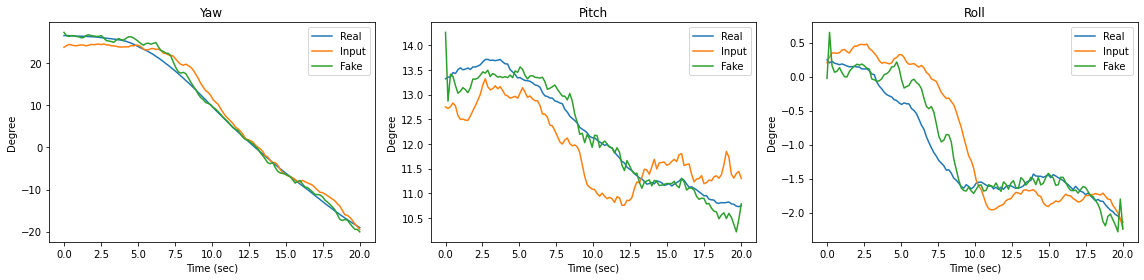

Train Epoch[731/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[731/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[731/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[732/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[732/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[732/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[733/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[733/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[733/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[734/1000] Step [01/02] d_

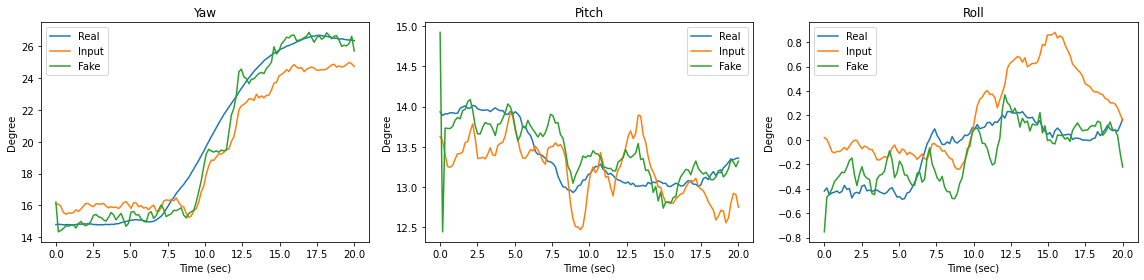

Train Epoch[741/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[741/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0007
Valid Epoch[741/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[742/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[742/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[742/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[743/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[743/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[743/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[744/1000] Step [01/02] d_

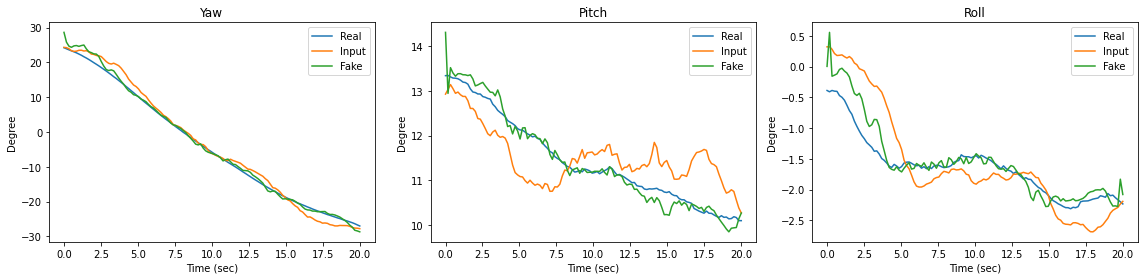

Train Epoch[751/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[751/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[751/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[752/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[752/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Valid Epoch[752/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[753/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[753/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[753/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[754/1000] Step [01/02] d_

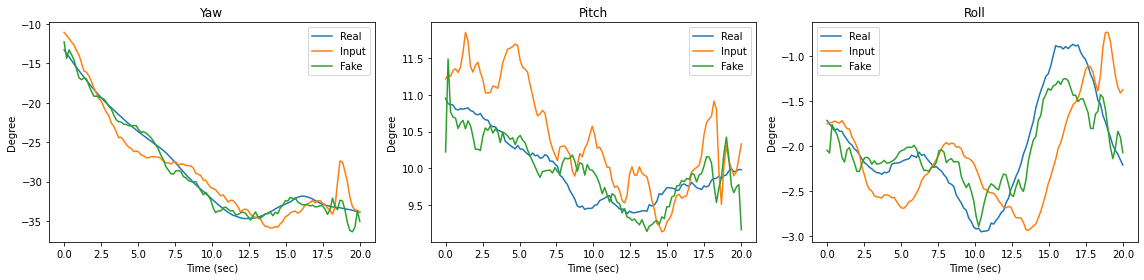

Train Epoch[761/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[761/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[761/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[762/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[762/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[762/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[763/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[763/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[763/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[764/1000] Step [01/02] d_

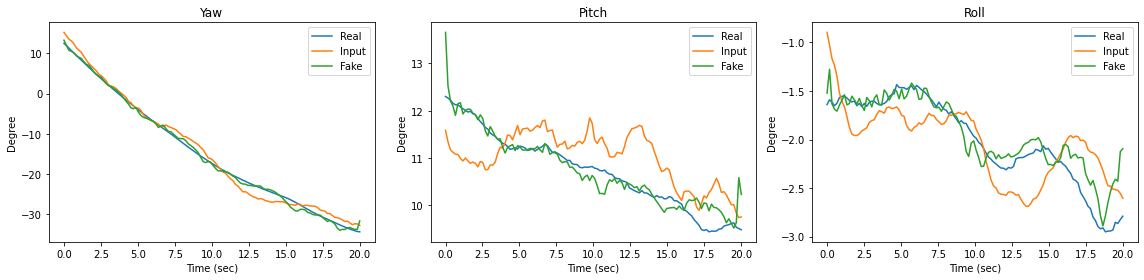

Train Epoch[771/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[771/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[771/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[772/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[772/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[772/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[773/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[773/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[773/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[774/1000] Step [01/02] d_

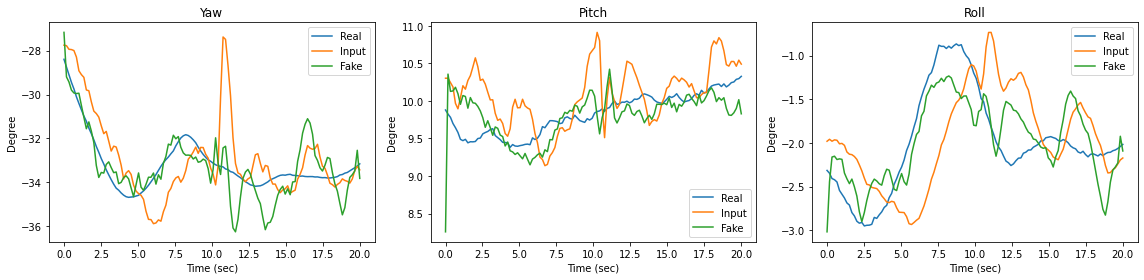

Train Epoch[781/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[781/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Valid Epoch[781/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[782/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[782/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0007
Valid Epoch[782/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[783/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[783/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[783/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[784/1000] Step [01/02] d_

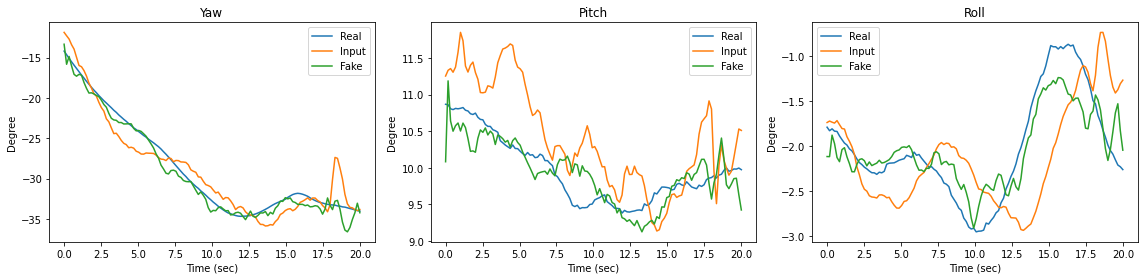

Train Epoch[791/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[791/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[791/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[792/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[792/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[792/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[793/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[793/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[793/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[794/1000] Step [01/02] d_

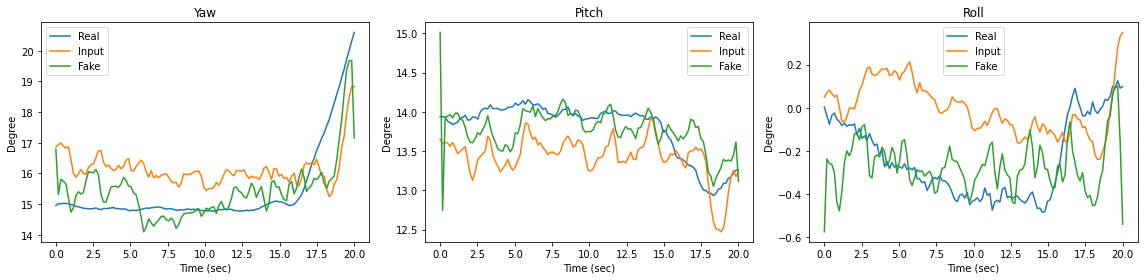

Train Epoch[801/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[801/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[801/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[802/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[802/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[802/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[803/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[803/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[803/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[804/1000] Step [01/02] d_

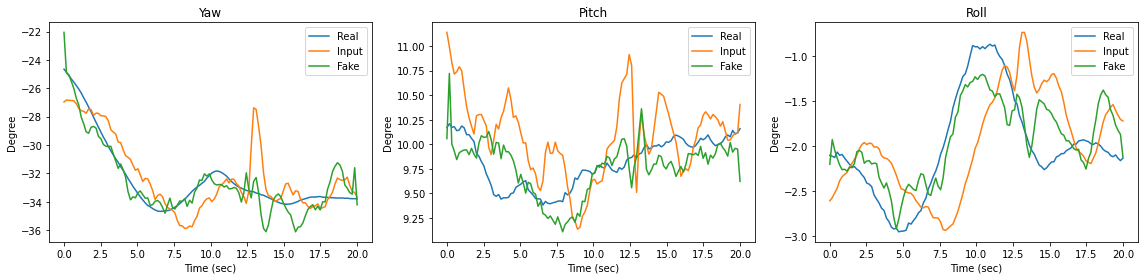

Train Epoch[811/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[811/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[811/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[812/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[812/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0007
Valid Epoch[812/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[813/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[813/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[813/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[814/1000] Step [01/02] d_

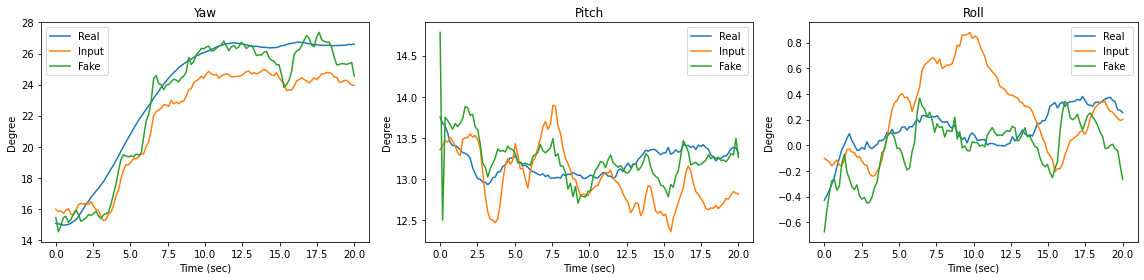

Train Epoch[821/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[821/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[821/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[822/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[822/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[822/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[823/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[823/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[823/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[824/1000] Step [01/02] d_

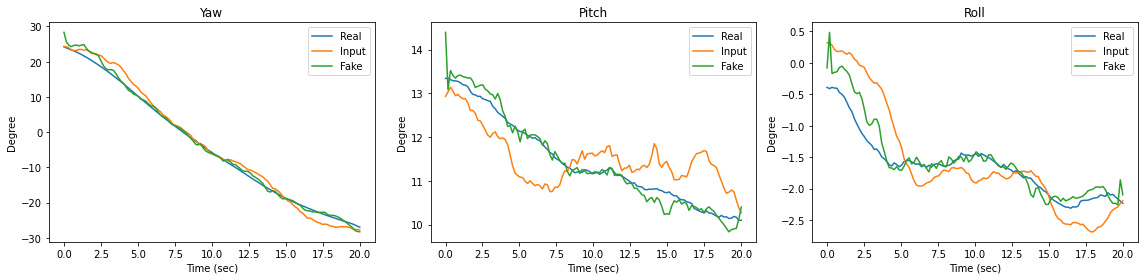

Train Epoch[831/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[831/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[831/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[832/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[832/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[832/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[833/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[833/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[833/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[834/1000] Step [01/02] d_

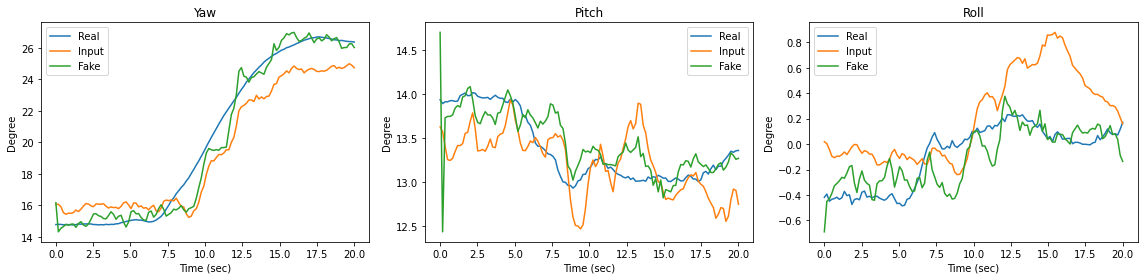

Train Epoch[841/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[841/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[841/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[842/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[842/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[842/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[843/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[843/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0007
Valid Epoch[843/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[844/1000] Step [01/02] d_

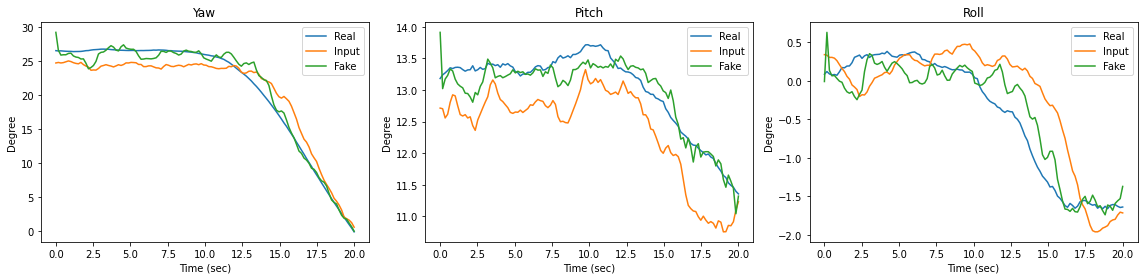

Train Epoch[851/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[851/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[851/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[852/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[852/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[852/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[853/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[853/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[853/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[854/1000] Step [01/02] d_

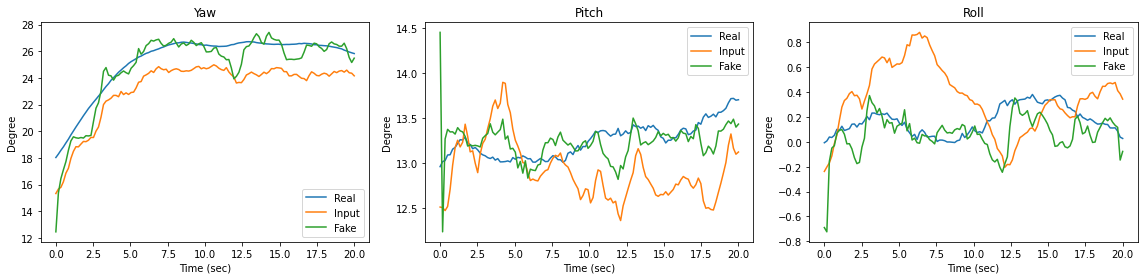

Train Epoch[861/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[861/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[861/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[862/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[862/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[862/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[863/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[863/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[863/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[864/1000] Step [01/02] d_

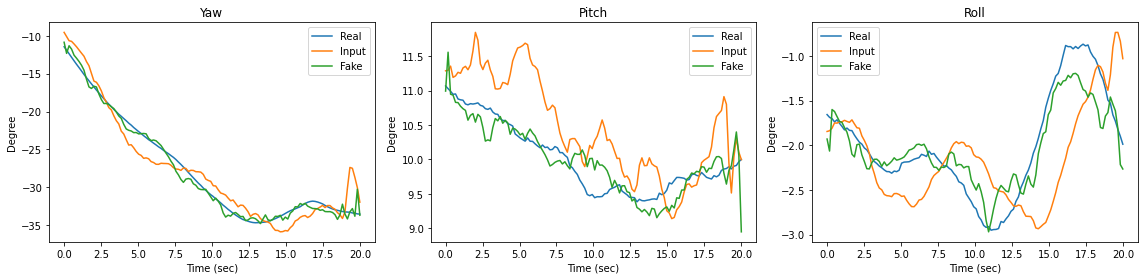

Train Epoch[871/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[871/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[871/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[872/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[872/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[872/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[873/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[873/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[873/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[874/1000] Step [01/02] d_

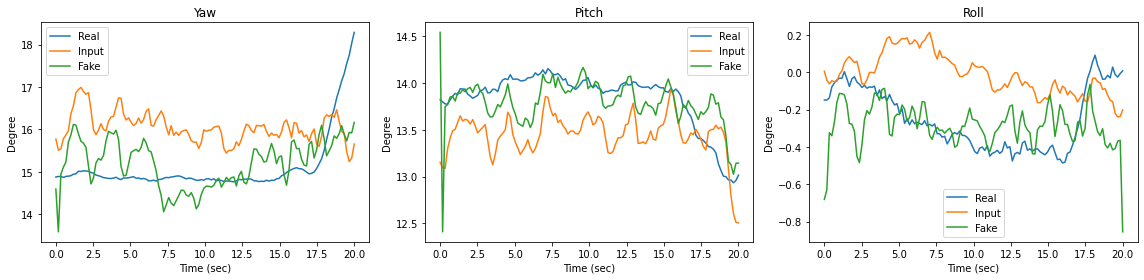

Train Epoch[881/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[881/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[881/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[882/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[882/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[882/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[883/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[883/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[883/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[884/1000] Step [01/02] d_

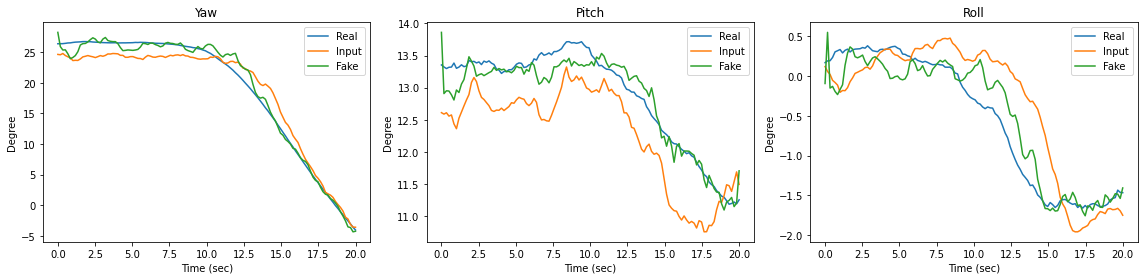

Train Epoch[891/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[891/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[891/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[892/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[892/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[892/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[893/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[893/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[893/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[894/1000] Step [01/02] d_

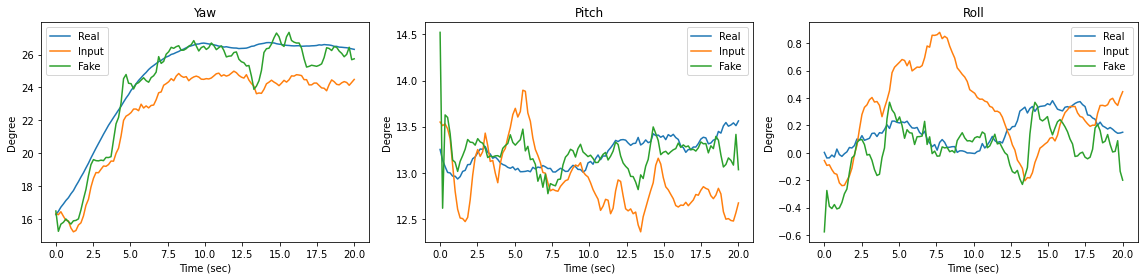

Train Epoch[901/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[901/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[901/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[902/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[902/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[902/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[903/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[903/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[903/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[904/1000] Step [01/02] d_

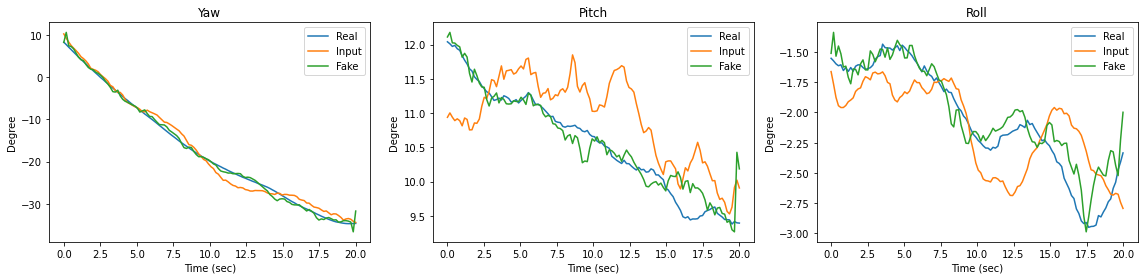

Train Epoch[911/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[911/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0006
Valid Epoch[911/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[912/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[912/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Valid Epoch[912/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[913/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[913/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[913/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[914/1000] Step [01/02] d_

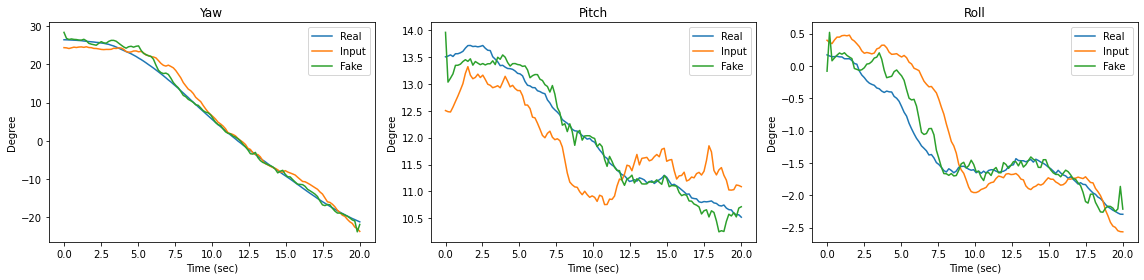

Train Epoch[921/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[921/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[921/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[922/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[922/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[922/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[923/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[923/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[923/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[924/1000] Step [01/02] d_

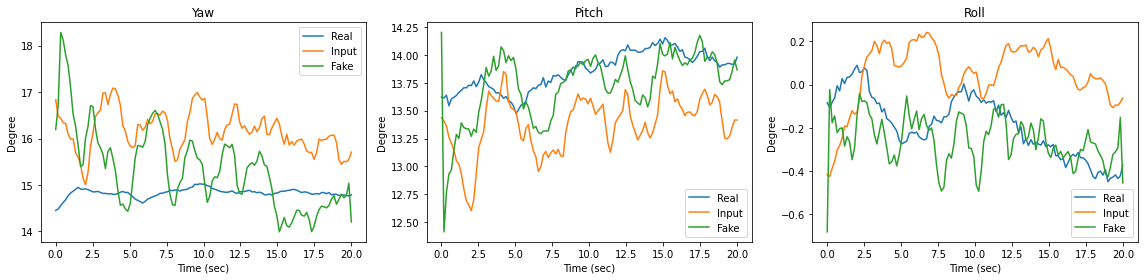

Train Epoch[931/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[931/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Valid Epoch[931/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[932/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[932/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[932/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[933/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[933/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[933/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[934/1000] Step [01/02] d_

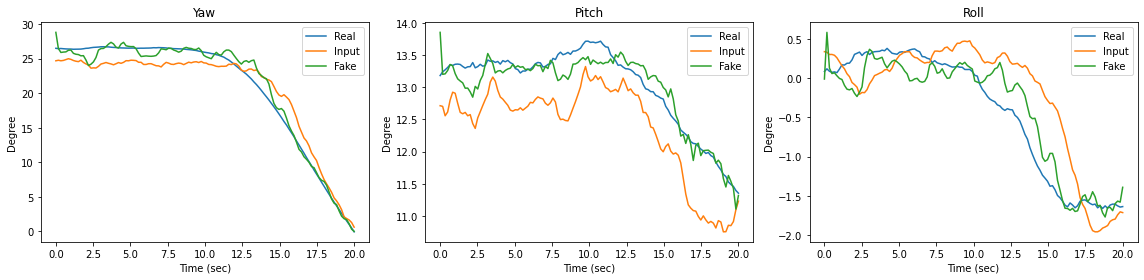

Train Epoch[941/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[941/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[941/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[942/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[942/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Valid Epoch[942/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[943/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[943/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[943/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[944/1000] Step [01/02] d_

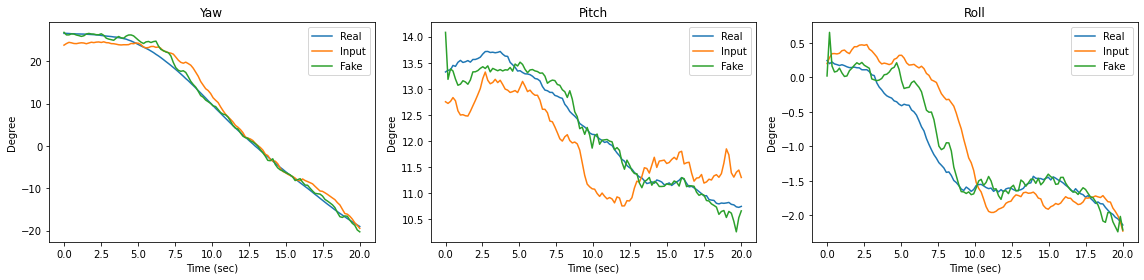

Train Epoch[951/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Train Epoch[951/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Valid Epoch[951/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[952/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[952/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Valid Epoch[952/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[953/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[953/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Valid Epoch[953/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[954/1000] Step [01/02] d_

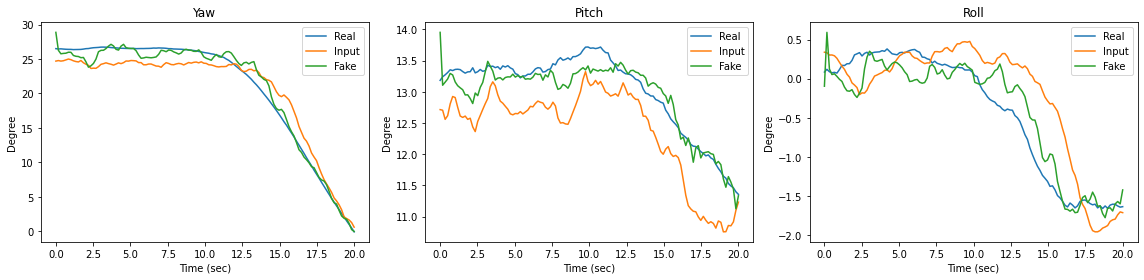

Train Epoch[961/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[961/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Valid Epoch[961/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[962/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[962/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Valid Epoch[962/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[963/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[963/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0004
Valid Epoch[963/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[964/1000] Step [01/02] d_

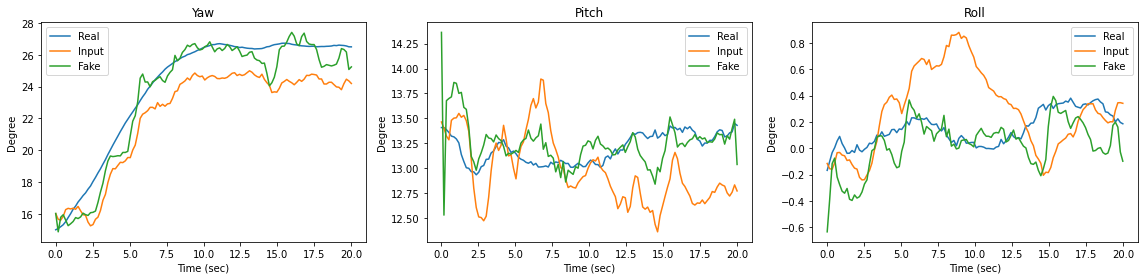

Train Epoch[971/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[971/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Valid Epoch[971/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[972/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[972/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Valid Epoch[972/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[973/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[973/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[973/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[974/1000] Step [01/02] d_

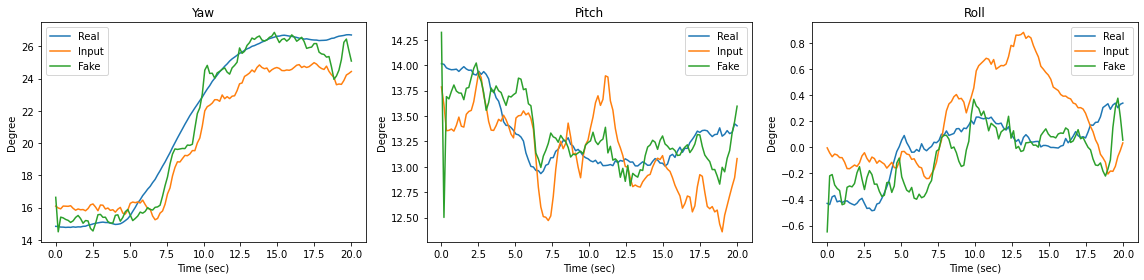

Train Epoch[981/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[981/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Valid Epoch[981/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[982/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0005
Train Epoch[982/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0007
Valid Epoch[982/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[983/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[983/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Valid Epoch[983/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[984/1000] Step [01/02] d_

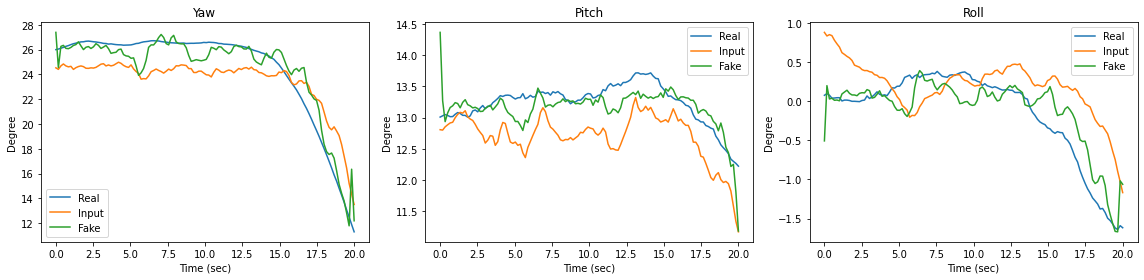

Train Epoch[991/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Train Epoch[991/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0003
Valid Epoch[991/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[992/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[992/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Valid Epoch[992/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[993/1000] Step [01/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[993/1000] Step [02/02] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Valid Epoch[993/1000] Step [01/01] d_loss: 0.0000, d_loss_real: 0.0000, d_loss_fake: 0.0000 g_loss: 0.0002
Train Epoch[994/1000] Step [01/02] d_

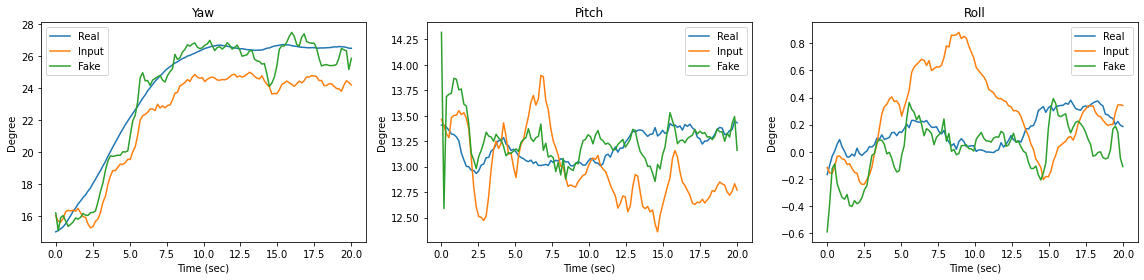

In [19]:
num_epochs = 1000

gen_weight = 0.1

for epoch in range(1, num_epochs + 1):
    # ===============================================================
    #                      Train Loop
    # ===============================================================
    total_steps = len(dl_train)
    for step, (x_real, x_fake) in enumerate(dl_train, 1):
        x_real = x_real.cuda()
        x_fake = x_fake.cuda()
        x_gen = G(x_fake)
        
        y_real = torch.ones(x_real.shape[0], 1, dtype=torch.float32).cuda()
        y_fake = torch.zeros(x_fake.shape[0], 1, dtype=torch.float32).cuda()
        
        pred_real = D(x_real)
        pred_fake = D(x_gen)
        
        d_loss_real = d_criterion(pred_real, y_real)
        d_loss_fake = d_criterion(pred_fake, y_fake)
        d_loss = (d_loss_real + d_loss_fake) * 0.5
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        x_gen = G(x_fake)
        pred_fake = D(x_gen)
        g_loss_real = g_criterion(x_gen, x_real)
        d_loss_fake = d_criterion(pred_fake, y_fake)
        g_loss = g_loss_real * gen_weight + d_loss_fake * (1 - gen_weight)
        
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        print(f'Train Epoch[{epoch:03d}/{num_epochs:03d}] Step [{step:02d}/{total_steps:02d}] '
              f'd_loss: {d_loss.item():.4f}, d_loss_real: {d_loss_real.item():.4f}, d_loss_fake: {d_loss_fake:.4f} '
              f'g_loss: {g_loss.item():.4f}')
        
    # ===============================================================
    #                      Validation Loop
    # ===============================================================
    total_steps = len(dl_test)
    for step, (x_real, x_fake) in enumerate(dl_test, 1):
        x_real = x_real.cuda()
        x_fake = x_fake.cuda()
        x_gen = G(x_fake)
        
        y_real = torch.ones(x_real.shape[0], 1, dtype=torch.float32).cuda()
        y_fake = torch.zeros(x_fake.shape[0], 1, dtype=torch.float32).cuda()
        
        pred_real = D(x_real)
        pred_fake = D(x_gen)
        
        d_loss_real = d_criterion(pred_real, y_real)
        d_loss_fake = d_criterion(pred_fake, y_fake)
        d_loss = (d_loss_real + d_loss_fake) * 0.5
        
        x_gen = G(x_fake)
        pred_fake = D(x_gen)
        g_loss_real = g_criterion(x_gen, x_real)
        d_loss_fake = d_criterion(pred_fake, y_fake)
        g_loss = g_loss_real * gen_weight + d_loss_fake * (1 - gen_weight)
        
        print(f'Valid Epoch[{epoch:03d}/{num_epochs:03d}] Step [{step:02d}/{total_steps:02d}] '
              f'd_loss: {d_loss.item():.4f}, d_loss_real: {d_loss_real.item():.4f}, d_loss_fake: {d_loss_fake:.4f} '
              f'g_loss: {g_loss.item():.4f}')
    
    if epoch % 10 == 0:
        plot_result()

# 할것

- D 모델 accuracy 구하기
- Yaw, pitch, roll RMS랑 99%tile 구하기